# Part 1: Baseline (Telco Churn)

**Goal of this baseline:**  
Build a **solid and reproducible** base model with:
- Minimal EDA (distributions, correlations, and short conclusions)
- Preprocessing with `Pipeline`/`ColumnTransformer` and **custom transformers**
- Base model: **Logistic Regression**
- Metrics on **validation** and **test**: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
- **Threshold tuning** (F1) on validation, applied later to test
- **Summary table** for later comparison with ensemble models (Bagging, Boosting, Stacking, Voting)


In [2]:
# !pip install pandas numpy matplotlib seaborn scipy
# !pip install sklearn

# !python -m pip --version
# !python -c "import sys,site; print(sys.executable); print(site.getsitepackages())"
# !python -m pip uninstall -y sklearn scikit-learn
# !python -m pip install --force-reinstall --no-deps matplotlib==3.10.0
# !python -m pip install -U matplotlib
# !python -m pip install -U pip setuptools wheel
# !python -m pip install -U scikit-learn
# !python -m pip check 



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import RobustScaler 
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 


### Variable description

The **Telco Customer Churn** dataset contains information on **7043 customers** from a telecommunications company.  
Each row represents a customer and the target (`Churn`) indicates whether they **left the service** (`Yes`) or **are still active** (`No`).

**Variables:**

- **customerID:** Unique customer identifier. Not useful for the model and removed.  
- **gender:** Customer gender (`Male`, `Female`).  
- **SeniorCitizen:** Whether the customer is a senior citizen (`1 = Yes`, `0 = No`).  
- **Partner:** Whether the customer has a partner (`Yes`, `No`).  
- **Dependents:** Whether the customer has dependents (children or others) (`Yes`, `No`).  
- **tenure:** Time as a customer, in **months** (0–72).  
- **PhoneService:** Whether they have phone service (`Yes`, `No`).  
- **MultipleLines:** Whether they have multiple lines (`Yes`, `No`, or `No phone service`).  
- **InternetService:** Type of internet service (`DSL`, `Fiber optic`, `No`).  
- **OnlineSecurity:** Online security service (`Yes`, `No`, or `No internet service`).  
- **OnlineBackup:** Online backup service (`Yes`, `No`, or `No internet service`).  
- **DeviceProtection:** Device protection (`Yes`, `No`, or `No internet service`).  
- **TechSupport:** Technical support (`Yes`, `No`, or `No internet service`).  
- **StreamingTV:** TV streaming (`Yes`, `No`, or `No internet service`).  
- **StreamingMovies:** Movie streaming (`Yes`, `No`, or `No internet service`).  
- **Contract:** Contract type (`Month-to-month`, `One year`, `Two year`).  
- **PaperlessBilling:** Whether billing is paperless (`Yes`, `No`).  
- **PaymentMethod:** Payment method (`Electronic check`, `Mailed check`, `Bank transfer (automatic)`, `Credit card (automatic)`).  
- **MonthlyCharges:** Current monthly charge (**USD/month**).  
- **TotalCharges:** Total amount charged since start (**accumulated USD**).  
- **Churn:** Target variable (`Yes` = customer left, `No` = still active).  

**Notes:**
- The variable `TotalCharges` comes as text and is converted to numeric. **11 missing values** are detected and imputed with the **median**.  
- The values `"No internet service"` and `"No phone service"` are replaced with `"No"` during preprocessing.  
- Categorical variables are encoded using **OneHotEncoder**, and numeric variables are scaled using **RobustScaler**.  
- Additionally, a new feature `tenure_x_monthly` is created (interaction between tenure and monthly charge).  


In [4]:
DATA_PATH = r"D:\Archivos de Usuario/Documents/Machine_Learning/Machine-Learning/Mid_Machine/WA_Fn-UseC_-Telco-Customer-Churn.csv" # Ajustar al path que tengan para que funcione

telco_df = pd.read_csv(DATA_PATH)
telco_df.head(10)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [5]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


### 1) EDA
Class distribution, numeric distributions, boxplots, class-wise densities by `Churn`, and correlations (Pearson).


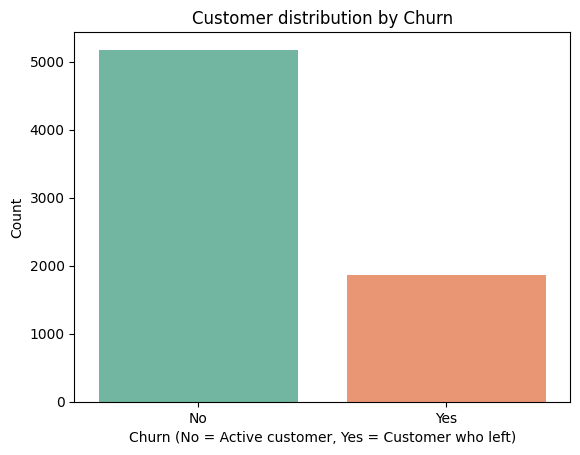

In [7]:
# Global class distribution
sns.countplot(x="Churn", data=telco_df, hue="Churn", palette="Set2", legend=False)
plt.title("Customer distribution by Churn")
plt.xlabel("Churn (No = Active customer, Yes = Customer who left)")
plt.ylabel("Count")
plt.show()


In [8]:
# Class proportion (Yes)
p_yes = (telco_df["Churn"].astype(str).str.strip() == "Yes").mean()
print(f"Proportion of Churn=Yes: {p_yes:.3f}")


Proportion of Churn=Yes: 0.265


In [9]:
# Missing values in numeric columns after converting TotalCharges
_chk = telco_df.copy()
_chk["TotalCharges"] = pd.to_numeric(_chk["TotalCharges"], errors="coerce")
print(_chk[["tenure","MonthlyCharges","TotalCharges"]].isna().sum())

tenure             0
MonthlyCharges     0
TotalCharges      11
dtype: int64


#### Distributions of key numeric variables


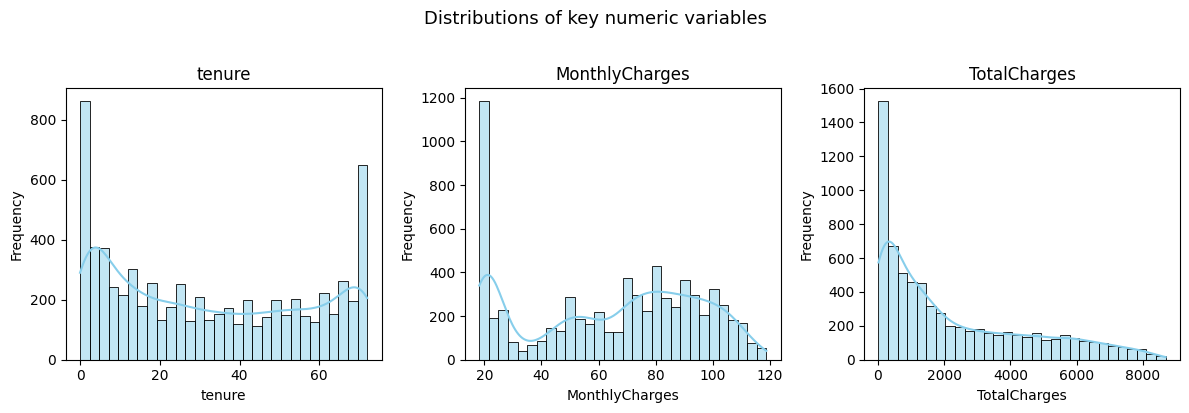

In [10]:
# Ensure TotalCharges is numeric
telco_num = telco_df.copy()
telco_num["TotalCharges"] = pd.to_numeric(telco_num["TotalCharges"], errors="coerce")

num_cols_quick = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.histplot(telco_num[col], bins=30, kde=True, color="skyblue", edgecolor="black")
    plt.title(f"{col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.suptitle("Distributions of key numeric variables", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

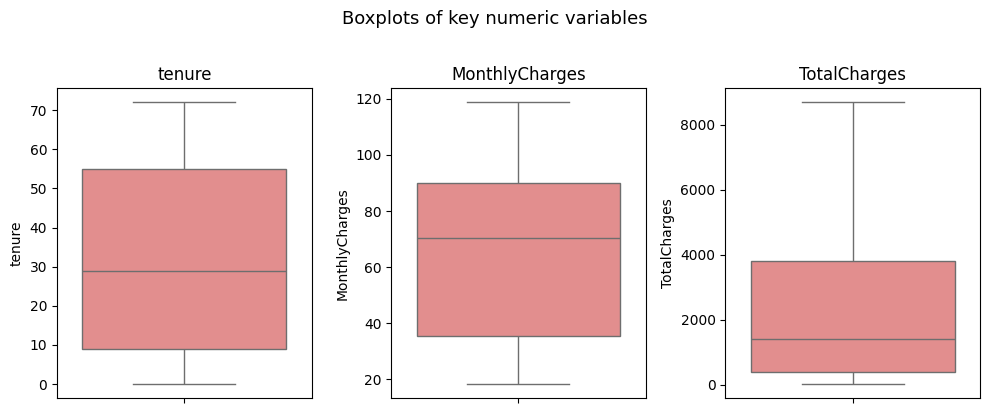

In [11]:
# Boxplots
plt.figure(figsize=(10, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=telco_num, y=col, color="lightcoral", fliersize=2)
    plt.title(f"{col}")
plt.suptitle("Boxplots of key numeric variables", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

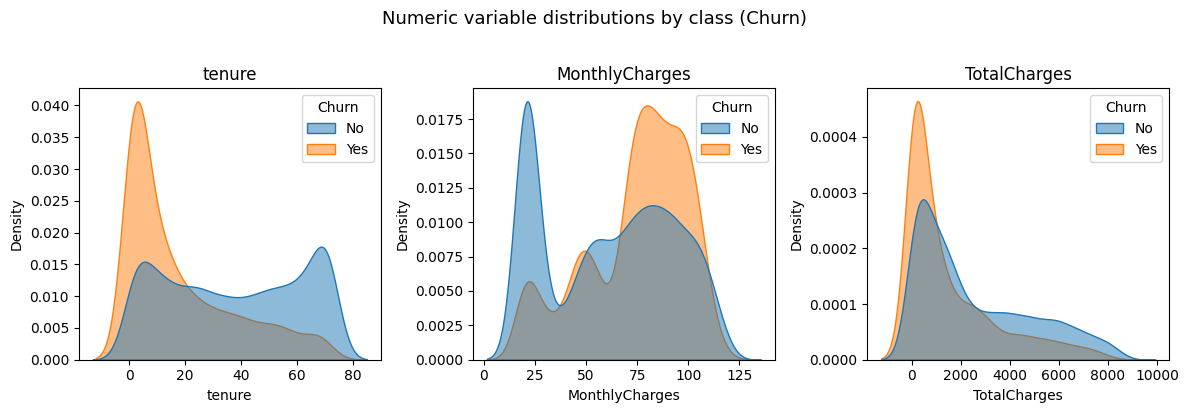

In [12]:
# Distributions by class (Churn)
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(
        data=telco_num, x=col, hue="Churn", fill=True, common_norm=False, alpha=0.5
    )
    plt.title(f"{col}")
plt.suptitle("Numeric variable distributions by class (Churn)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

#### Numeric correlations


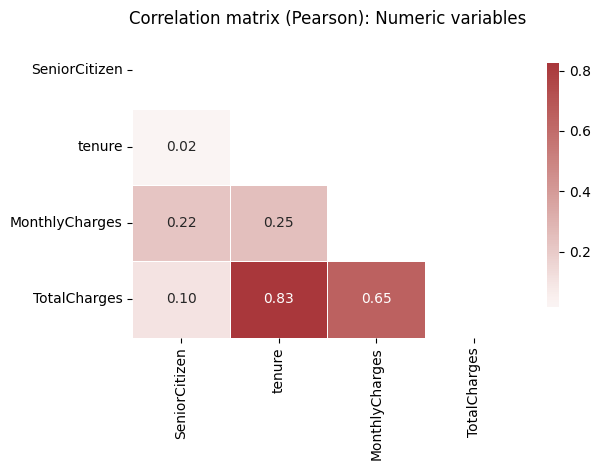

In [13]:
# Numeric correlations with Pearson
num_df = telco_df.copy()
num_df["TotalCharges"] = pd.to_numeric(num_df.get("TotalCharges", pd.Series(dtype=float)), errors="coerce")

num_only = num_df.select_dtypes(include=[np.number])

# Correlation matrix (Pearson)
corr_pearson = num_only.corr(method="pearson")

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

plt.figure(figsize=(6.4, 4.8))
sns.heatmap(
    corr_pearson,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title("Correlation matrix (Pearson): Numeric variables")
plt.tight_layout()
plt.show()


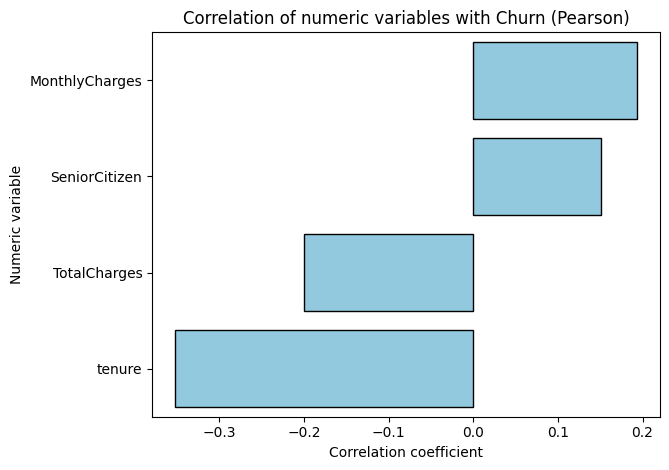

In [14]:
# Correlation of numeric variables with the target (Churn)
# Convert Churn to binary (Yes=1, No=0)
y_bin = (telco_df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# Direct correlations
corr_with_target = num_only.corrwith(y_bin).sort_values(ascending=False)

plt.figure(figsize=(6.8, 4.8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, color="skyblue", edgecolor="black")
plt.title("Correlation of numeric variables with Churn (Pearson)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Numeric variable")
plt.tight_layout()
plt.show()


### Scatter plots


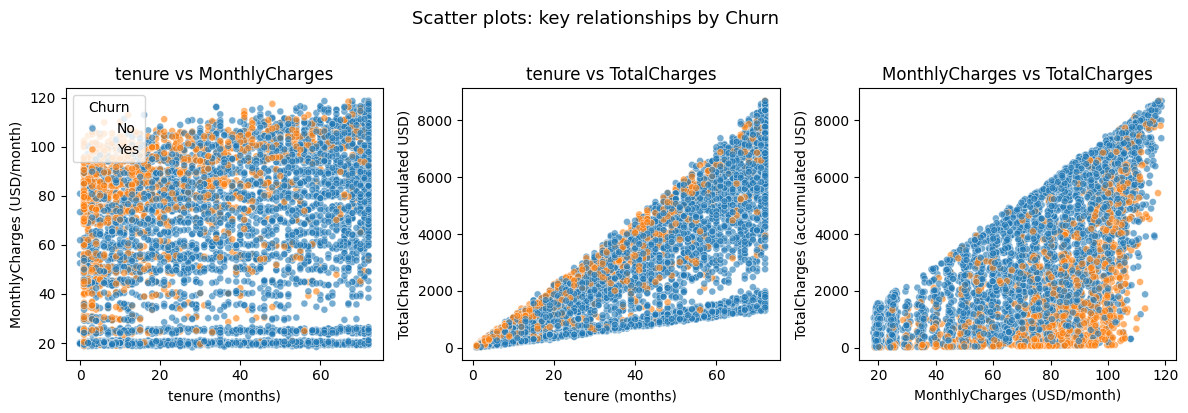

In [15]:
_sc = telco_df.copy()
_sc["TotalCharges"] = pd.to_numeric(_sc["TotalCharges"], errors="coerce")

plt.figure(figsize=(12, 4))
# 1) tenure vs MonthlyCharges
plt.subplot(1, 3, 1)
sns.scatterplot(
    data=_sc, x="tenure", y="MonthlyCharges", hue="Churn", alpha=0.6, s=25
)
plt.title("tenure vs MonthlyCharges")
plt.xlabel("tenure (months)")
plt.ylabel("MonthlyCharges (USD/month)")

# 2) tenure vs TotalCharges (accumulated relation)
plt.subplot(1, 3, 2)
sns.scatterplot(
    data=_sc, x="tenure", y="TotalCharges", hue="Churn", alpha=0.6, s=25, legend=False
)
plt.title("tenure vs TotalCharges")
plt.xlabel("tenure (months)")
plt.ylabel("TotalCharges (accumulated USD)")

# 3) MonthlyCharges vs TotalCharges
plt.subplot(1, 3, 3)
sns.scatterplot(
    data=_sc, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.6, s=25, legend=False
)
plt.title("MonthlyCharges vs TotalCharges")
plt.xlabel("MonthlyCharges (USD/month)")
plt.ylabel("TotalCharges (accumulated USD)")

plt.suptitle("Scatter plots: key relationships by Churn", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


### Utilities and transformers


In [16]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return train_set, val_set, test_set

In [17]:
def find_best_threshold_by_f1(y_true, y_proba_yes, pos_label='Yes', n_steps=201):
    best_thr, best_f1 = 0.5, -1.0
    best_p, best_r = None, None
    thresholds = np.linspace(0.0, 1.0, n_steps)
    for thr in thresholds:
        y_hat = np.where(y_proba_yes >= thr, pos_label, 'No')
        f1 = f1_score(y_true, y_hat, pos_label=pos_label)
        if f1 > best_f1:
            best_f1 = f1; best_thr = thr
            best_p = precision_score(y_true, y_hat, pos_label=pos_label)
            best_r = recall_score(y_true, y_hat, pos_label=pos_label)
    return best_thr, best_f1, best_p, best_r


def find_threshold_by_recall(y_true, y_proba_yes, target_recall=0.75, pos_label='Yes', n_steps=201):
    best_thr = 0.5; best_f1 = -1.0
    thresholds = np.linspace(0.0, 1.0, n_steps)
    for thr in thresholds:
        y_hat = np.where(y_proba_yes >= thr, pos_label, 'No')
        r = recall_score(y_true, y_hat, pos_label=pos_label)
        if r >= target_recall:
            f1 = f1_score(y_true, y_hat, pos_label=pos_label)
            if f1 > best_f1:
                best_f1 = f1; best_thr = thr
    return best_thr, best_f1

In [18]:
class CategoricalServiceCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._cols = None

    def fit(self, X, y=None):
        self._cols = list(X.columns)
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        for c in self._cols:
            Xc[c] = (
                Xc[c].astype(str)
                    .str.strip()
                    .replace({'No internet service': 'No', 'No phone service': 'No'})
            )
        return Xc

In [19]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(
            sparse_output=False,
            handle_unknown="ignore",
            drop="if_binary"
        )
        self._cat_cols = None
        self._columns_out = None

    def fit(self, X, y=None):
        Xc = X.astype(str)
        self._cat_cols = list(Xc.columns)
        self._oh.fit(Xc)
        self._columns_out = list(self._oh.get_feature_names_out(self._cat_cols))
        return self

    def transform(self, X, y=None):
        Xc = X.astype(str)
        return self._oh.transform(Xc)

    def get_feature_names_out(self, input_features=None):
        cols = input_features if input_features is not None else self._cat_cols
        return self._oh.get_feature_names_out(cols)

In [20]:
class NumericFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, add_interaction=True, drop_totalcharges=True):
        self.add_interaction = add_interaction
        self.drop_totalcharges = drop_totalcharges
        self._cols = None

    def fit(self, X, y=None):
        self._cols = list(X.columns)
        return self

    def transform(self, X, y=None):
        Xn = X.copy()
        if 'TotalCharges' in Xn.columns:
            Xn['TotalCharges'] = pd.to_numeric(Xn['TotalCharges'], errors='coerce')

        if self.add_interaction and {'tenure', 'MonthlyCharges'}.issubset(Xn.columns):
            Xn['tenure_x_monthly'] = Xn['tenure'] * Xn['MonthlyCharges']

        if self.drop_totalcharges and 'TotalCharges' in Xn.columns:
            Xn = Xn.drop(columns=['TotalCharges'])

        return Xn

In [21]:
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self, add_interaction=True, drop_totalcharges=True, drop_cols=None):
        self.add_interaction = add_interaction
        self.drop_totalcharges = drop_totalcharges
        self.drop_cols = drop_cols if drop_cols is not None else ['customerID']
        self._ct = None
        self._num_cols = None
        self._cat_cols = None
        self._columns_out = None

    def fit(self, X, y=None):
        Xw = X.drop(columns=[c for c in self.drop_cols if c in X.columns], errors='ignore')

        num_cols = list(Xw.select_dtypes(include=['int64', 'float64']).columns)
        if 'TotalCharges' in Xw.columns and 'TotalCharges' not in num_cols:
            num_cols.append('TotalCharges')
        self._num_cols = num_cols

        # categoricals
        self._cat_cols = [c for c in Xw.columns if c not in self._num_cols]

        # pipelines
        num_pipeline = Pipeline([
            ('feats', NumericFeaturizer(add_interaction=self.add_interaction,
                                        drop_totalcharges=self.drop_totalcharges)),
            ('imputer', SimpleImputer(strategy="median")),
            ('rbst_scaler', RobustScaler())
        ])

        cat_pipeline = Pipeline([
            ('clean', CategoricalServiceCleaner()),
            ('oh_df', CustomOneHotEncoder())
        ])

        # ColumnTransformer
        self._ct = ColumnTransformer([
            ("num", num_pipeline, self._num_cols),
            ("cat", cat_pipeline, self._cat_cols),
        ], remainder='drop')

        self._ct.fit(Xw)

        num_out = list(self._num_cols)
        if self.add_interaction and {'tenure','MonthlyCharges'}.issubset(self._num_cols):
            num_out.append('tenure_x_monthly')
        if self.drop_totalcharges and 'TotalCharges' in num_out:
            num_out.remove('TotalCharges')

        oh = self._ct.named_transformers_['cat'].named_steps['oh_df']
        cat_out = list(oh.get_feature_names_out(self._cat_cols))

        self._columns_out = num_out + cat_out
        return self

    def transform(self, X, y=None):
        Xw = X.drop(columns=[c for c in self.drop_cols if c in X.columns], errors='ignore')
        Xt = self._ct.transform(Xw)
        return pd.DataFrame(Xt, columns=self._columns_out, index=X.index)

In [22]:
df = pd.read_csv(DATA_PATH)
df.shape

(7043, 21)

In [23]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### Stratified split and preprocessing


In [24]:
train_set, val_set, test_set = train_val_test_split(df, stratify='Churn', rstate=42)
print("\nLength of the Training Set:", len(train_set))
print("Length of the Validation Set:", len(val_set))
print("Length of Test Set:", len(test_set))


Length of the Training Set: 4225
Length of the Validation Set: 1409
Length of Test Set: 1409


In [25]:
# For each subset, separate labels from features
X_df  = df.drop("Churn", axis=1)
y_df  = df["Churn"].copy()

X_train = train_set.drop("Churn", axis=1); y_train = train_set["Churn"].copy()
X_val   = val_set.drop("Churn", axis=1);   y_val   = val_set["Churn"].copy()
X_test  = test_set.drop("Churn", axis=1);  y_test  = test_set["Churn"].copy()


In [26]:
data_preparer = DataFramePreparer(
    add_interaction=True,
    drop_totalcharges=False,
    drop_cols=['customerID']
)

In [27]:
data_preparer.fit(X_train)

DataFramePreparer(drop_cols=['customerID'], drop_totalcharges=False)

In [28]:
# Transform train / val / test
X_train_prep = data_preparer.transform(X_train)
X_val_prep   = data_preparer.transform(X_val)
X_test_prep  = data_preparer.transform(X_test)

print("\nColumns:", list(X_train_prep.columns)[:10])
print("Shapes -> Train:", X_train_prep.shape, " Val:", X_val_prep.shape, " Test:", X_test_prep.shape)


Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_x_monthly', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes']
Shapes -> Train: (4225, 27)  Val: (1409, 27)  Test: (1409, 27)


### Baseline: Logistic Regression (validation)
We report **Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC** and curves; then we tune the **threshold** by F1.


In [29]:
clf = LogisticRegression(max_iter=5000, random_state=42)

In [30]:
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=5000, random_state=42)


Confusion matrix (validation):
 [[941  94]
 [153 221]]


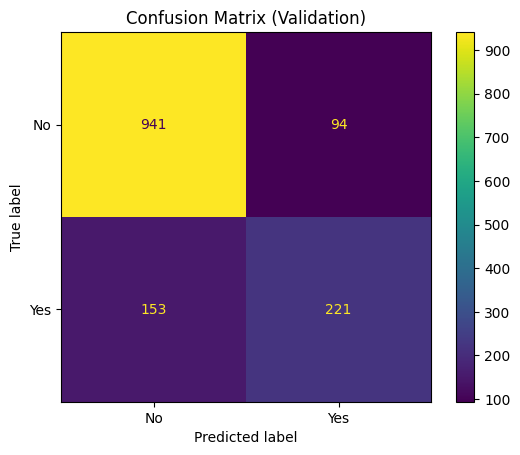

In [31]:
# Prediction on validation (threshold 0.5)
y_pred_val = clf.predict(X_val_prep)
cm_val = confusion_matrix(y_val, y_pred_val)
print("\nConfusion matrix (validation):\n", cm_val)

labels = ['No', 'Yes']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix (Validation)")
plt.show()

In [32]:
# Validation metrics @0.5
acc_val  = accuracy_score(y_val, y_pred_val)
prec_val = precision_score(y_val, y_pred_val, pos_label='Yes')
rec_val  = recall_score(y_val, y_pred_val, pos_label='Yes')
f1_val   = f1_score(y_val, y_pred_val, pos_label='Yes')
print("Accuracy (val):", acc_val)
print("Precision (val, pos='Yes'):", prec_val)
print("Recall    (val, pos='Yes'):",  rec_val)
print("F1 score  (val, pos='Yes'):",  f1_val)


Accuracy (val): 0.8246983676366217
Precision (val, pos='Yes'): 0.7015873015873015
Recall    (val, pos='Yes'): 0.5909090909090909
F1 score  (val, pos='Yes'): 0.6415094339622641


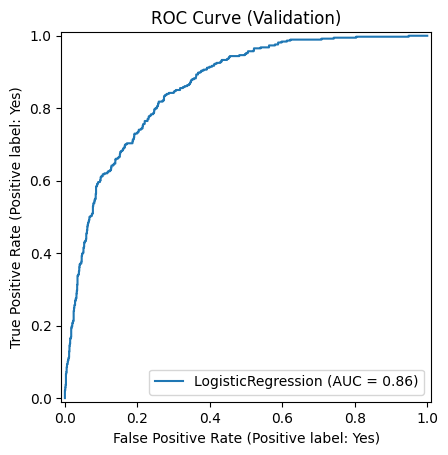

In [33]:
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)
plt.title("ROC Curve (Validation)")
plt.show()


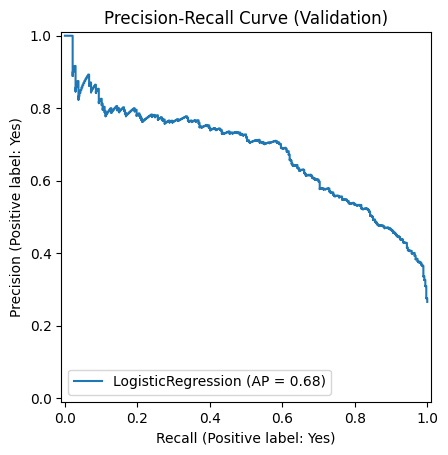

In [34]:
PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val, pos_label='Yes')
plt.title("Precision-Recall Curve (Validation)")
plt.show()

In [35]:
val_proba_yes = clf.predict_proba(X_val_prep)[:, list(clf.classes_).index('Yes')]
roc_auc_val = roc_auc_score(y_val == 'Yes', val_proba_yes)
pr_auc_val  = average_precision_score(y_val == 'Yes', val_proba_yes)
print("ROC-AUC (val):", roc_auc_val)
print("PR-AUC  (val):", pr_auc_val)

ROC-AUC (val): 0.8597974631222713
PR-AUC  (val): 0.6768866466847183


### Threshold tuning by F1 (validation) and final evaluation on test
Fix the threshold on validation and apply it to test **once**.


In [36]:
# Optimal threshold by F1 (validation)
best_thr, best_f1, best_p, best_r = find_best_threshold_by_f1(
    y_val, val_proba_yes, pos_label='Yes', n_steps=201
)
print("\nBest threshold by F1 (val):", best_thr)
print("Val @best_thr -> F1:", best_f1, " Precision:", best_p, " Recall:", best_r)


Best threshold by F1 (val): 0.48
Val @best_thr -> F1: 0.6461538461538462  Precision: 0.6774193548387096  Recall: 0.6176470588235294



Confusion matrix (test, tuned thr):
 [[895 140]
 [170 204]]


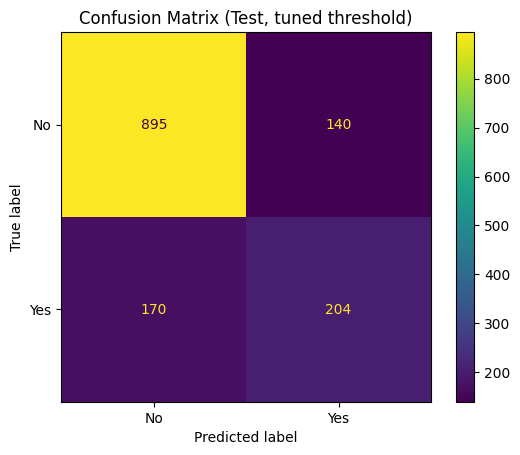

In [37]:
# Test with the optimal threshold
test_proba_yes = clf.predict_proba(X_test_prep)[:, list(clf.classes_).index('Yes')]
y_pred_test_thr = np.where(test_proba_yes >= best_thr, 'Yes', 'No')

cm_test = confusion_matrix(y_test, y_pred_test_thr)
print("\nConfusion matrix (test, tuned thr):\n", cm_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix (Test, tuned threshold)")
plt.show()

In [38]:
# Test metrics @best_thr
acc_test  = accuracy_score(y_test, y_pred_test_thr)
prec_test = precision_score(y_test, y_pred_test_thr, pos_label='Yes')
rec_test  = recall_score(y_test, y_pred_test_thr, pos_label='Yes')
f1_test   = f1_score(y_test, y_pred_test_thr, pos_label='Yes')
roc_auc_test = roc_auc_score(y_test == 'Yes', test_proba_yes)
pr_auc_test  = average_precision_score(y_test == 'Yes', test_proba_yes)

print("Accuracy (test):", acc_test)
print("Precision (test, pos='Yes'):", prec_test)
print("Recall    (test, pos='Yes'):",  rec_test)
print("F1 score  (test, pos='Yes'):",  f1_test)
print("ROC-AUC (test):", roc_auc_test)
print("PR-AUC  (test):", pr_auc_test)


Accuracy (test): 0.7799858055358411
Precision (test, pos='Yes'): 0.5930232558139535
Recall    (test, pos='Yes'): 0.5454545454545454
F1 score  (test, pos='Yes'): 0.5682451253481894
ROC-AUC (test): 0.8320287271693921
PR-AUC  (test): 0.622145410744846


### Summary table (Baseline)
Ready for comparison with Bagging, Boosting, Stacking, and Voting.


In [39]:
summary_baseline = pd.DataFrame({
    "split": ["val", "test"],
    "Accuracy": [acc_val, acc_test],
    "F1_PosYes": [f1_val, f1_test],
    "Precision_PosYes": [prec_val, prec_test],
    "Recall_PosYes": [rec_val, rec_test],
    "ROC_AUC": [roc_auc_val, roc_auc_test],
    "PR_AUC": [pr_auc_val, pr_auc_test],
    "Threshold_Used": [0.5, best_thr]
})
print("\nBaseline summary:")
print(summary_baseline.to_string(index=False))



Baseline summary:
split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
  val  0.824698   0.641509          0.701587       0.590909 0.859797 0.676887            0.50
 test  0.779986   0.568245          0.593023       0.545455 0.832029 0.622145            0.48


## Part 2: Ensemble Models (Bagging, Boosting, Stacking, Voting)

We extend the project with **four ensemble models**, using the same data split and preprocessing from Part 1:

1) **Bagging**: Random Forest  
2) **Boosting**: CatBoost  
3) **Stacking**: Base: RandomForest + GradientBoosting, Meta: LogisticRegression, `cv=5`  
4) **Voting**: RF + SVM, evaluated with **hard** and **soft** voting

All models tune the threshold on **validation** by **max F1**, then apply it **once** to the test set. The final table appends to the baseline summary.


### Hyperparameter Selection (used)

| Model                          | Description                                                             | Key Hyperparameters                                                                 |
|--------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| Bagging (Random Forest)        | Bagging using Random Forest to aggregate multiple decision trees.       | `n_estimators=100`, `max_depth=None`, `min_samples_split=2`, `bootstrap=True`      |
| Boosting (CatBoost)            | Boosting using CatBoost to iteratively improve weak learners.           | `iterations=500`, `learning_rate=0.1`, `depth=6`, `l2_leaf_reg=3`, `random_state=42` |
| Stacking Classifier            | Stacking with RF + GB as base; LR as meta-model.                        | `estimators=[('rf', RF), ('gb', GB)]`, `final_estimator=LogisticRegression`, `cv=5`|
| Voting Classifier (Hard/Soft)  | Voting ensemble using Random Forest and SVM.                            | `estimators=[('rf', RF), ('svm', SVC)]`, `voting='hard'/'soft'`, `probability=True` for SVC |


In [40]:
# !pip install catboost

In [41]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [42]:
def evaluate_with_threshold(model_name, clf, X_tr, y_tr, X_val, y_val, X_te, y_te, tune_threshold=True):
    clf.fit(X_tr, y_tr)

    classes = list(clf.classes_) if hasattr(clf, "classes_") else ['No','Yes']
    pos_idx = classes.index('Yes') if 'Yes' in classes else 1

    # Validation proba for 'Yes'
    val_proba_yes = clf.predict_proba(X_val)[:, pos_idx]
    thr_used = 0.5
    if tune_threshold:
        best_thr, best_f1, best_p, best_r = find_best_threshold_by_f1(y_val, val_proba_yes, pos_label='Yes', n_steps=201)
        thr_used = float(best_thr)

    # Validation metrics @thr_used
    y_val_pred = np.where(val_proba_yes >= thr_used, 'Yes', 'No')
    acc_val  = accuracy_score(y_val, y_val_pred)
    prec_val = precision_score(y_val, y_val_pred, pos_label='Yes')
    rec_val  = recall_score(y_val, y_val_pred, pos_label='Yes')
    f1_val   = f1_score(y_val, y_val_pred, pos_label='Yes')
    roc_auc_val = roc_auc_score(y_val == 'Yes', val_proba_yes)
    pr_auc_val  = average_precision_score(y_val == 'Yes', val_proba_yes)

    # Test metrics @thr_used
    te_proba_yes = clf.predict_proba(X_te)[:, pos_idx]
    y_te_pred = np.where(te_proba_yes >= thr_used, 'Yes', 'No')
    acc_te  = accuracy_score(y_te, y_te_pred)
    prec_te = precision_score(y_te, y_te_pred, pos_label='Yes')
    rec_te  = recall_score(y_te, y_te_pred, pos_label='Yes')
    f1_te   = f1_score(y_te, y_te_pred, pos_label='Yes')
    roc_auc_te = roc_auc_score(y_te == 'Yes', te_proba_yes)
    pr_auc_te  = average_precision_score(y_te == 'Yes', te_proba_yes)

    # One summary per split
    out = pd.DataFrame({
        "model":   [model_name, model_name],
        "split":   ["val", "test"],
        "Accuracy": [acc_val, acc_te],
        "F1_PosYes": [f1_val, f1_te],
        "Precision_PosYes": [prec_val, prec_te],
        "Recall_PosYes": [rec_val, rec_te],
        "ROC_AUC": [roc_auc_val, roc_auc_te],
        "PR_AUC": [pr_auc_val, pr_auc_te],
        "Threshold_Used": [thr_used, thr_used],
    })
    return out

### What we do
We train RandomForest (bagging), CatBoost (boosting), a Stacking classifier (RF+GB -> LR), and a Voting classifier (RF+SVM, hard/soft). For each model, we tune the decision threshold on validation by maximum F1 and then apply the selected threshold once to the test set.


In [43]:
# 1) Bagging — Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

summary_rf = evaluate_with_threshold(
    model_name="Bagging (RandomForest)",
    clf=rf,
    X_tr=X_train_prep, y_tr=y_train,
    X_val=X_val_prep,  y_val=y_val,
    X_te=X_test_prep,  y_te=y_test,
    tune_threshold=True
)

print("Random Forest summary:")
print(summary_rf.to_string(index=False))


Random Forest summary:
                 model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
Bagging (RandomForest)   val  0.772889   0.625293          0.556250       0.713904 0.837927 0.638168           0.335
Bagging (RandomForest)  test  0.756565   0.597890          0.532359       0.681818 0.809559 0.600314           0.335


In [44]:
# 2) Boosting — CatBoost (works fine with the prepared numeric matrix)
cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)

summary_cat = evaluate_with_threshold(
    model_name="Boosting (CatBoost)",
    clf=cat,
    X_tr=X_train_prep, y_tr=y_train,
    X_val=X_val_prep,  y_val=y_val,
    X_te=X_test_prep,  y_te=y_test,
    tune_threshold=True
)

print("CatBoost summary:")
print(summary_cat.to_string(index=False))

CatBoost summary:
              model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
Boosting (CatBoost)   val  0.755855   0.632479          0.526690       0.791444 0.838956 0.647366           0.225
Boosting (CatBoost)  test  0.732434   0.593312          0.497288       0.735294 0.811349 0.595764           0.225


In [45]:
# 3) Stacking — (RF + GB) -> LR
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

gb_base = GradientBoostingClassifier(random_state=42)
meta_lr = LogisticRegression(max_iter=5000, random_state=42)

stack = StackingClassifier(
    estimators=[("rf", rf_base), ("gb", gb_base)],
    final_estimator=meta_lr,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

summary_stack = evaluate_with_threshold(
    model_name="Stacking (RF+GB -> LR)",
    clf=stack,
    X_tr=X_train_prep, y_tr=y_train,
    X_val=X_val_prep,  y_val=y_val,
    X_te=X_test_prep,  y_te=y_test,
    tune_threshold=True
)

print("Stacking summary:")
print(summary_stack.to_string(index=False))


Stacking summary:
                 model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
Stacking (RF+GB -> LR)   val  0.806955   0.640212          0.633508       0.647059 0.855061 0.669349           0.375
Stacking (RF+GB -> LR)  test  0.781405   0.591512          0.586842       0.596257 0.829013 0.628560           0.375


In [46]:
# 4) Voting — RF + SVM (hard & soft)
rf_v = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

svm_v = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,  # required for 'soft' voting and for thresholding
    random_state=42
)

vote_hard = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="hard",
    n_jobs=-1
)

# For hard voting, we emulate predict_proba using a wrapper to keep the same evaluation
class HardVotingWrapper:
    def __init__(self, vc):
        self.vc = vc
    def fit(self, X, y):
        self.vc.fit(X, y); return self
    @property
    def classes_(self):
        return self.vc.classes_
    def predict_proba(self, X):
        preds = self.vc.predict(X)
        proba_yes = (preds == 'Yes').astype(float)
        proba_no  = 1.0 - proba_yes
        return np.vstack([proba_no, proba_yes]).T

summary_vote_hard = evaluate_with_threshold(
    model_name="Voting (Hard: RF+SVM)",
    clf=HardVotingWrapper(vote_hard),
    X_tr=X_train_prep, y_tr=y_train,
    X_val=X_val_prep,  y_val=y_val,
    X_te=X_test_prep,  y_te=y_test,
    tune_threshold=True
)

vote_soft = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="soft",
    n_jobs=-1
)

summary_vote_soft = evaluate_with_threshold(
    model_name="Voting (Soft: RF+SVM)",
    clf=vote_soft,
    X_tr=X_train_prep, y_tr=y_train,
    X_val=X_val_prep,  y_val=y_val,
    X_te=X_test_prep,  y_te=y_test,
    tune_threshold=True
)

print("Voting (hard) summary:")
print(summary_vote_hard.to_string(index=False))
print("\nVoting (soft) summary:")
print(summary_vote_soft.to_string(index=False))


Voting (hard) summary:
                model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
Voting (Hard: RF+SVM)   val  0.801987   0.521441          0.727273       0.406417 0.675672 0.453135           0.005
Voting (Hard: RF+SVM)  test  0.781405   0.479730          0.651376       0.379679 0.653125 0.411970           0.005

Voting (soft) summary:
                model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
Voting (Soft: RF+SVM)   val  0.794890   0.642769          0.597701       0.695187 0.845413 0.662169           0.305
Voting (Soft: RF+SVM)  test  0.776437   0.620024          0.564835       0.687166 0.819964 0.617700           0.305


In [47]:
# Define the common column order (adds 'model' at the end)
cols_order = [
    "split", "Accuracy", "F1_PosYes", "Precision_PosYes", "Recall_PosYes",
    "ROC_AUC", "PR_AUC", "Threshold_Used", "model"
]

# Ensure baseline summary has a 'model' column and the same column order
summary_baseline = summary_baseline.assign(model=["Baseline (LogReg)", "Baseline (LogReg)"])
summary_baseline = summary_baseline[cols_order]

# Reorder other summaries to match
def _reorder(df):
    return df[cols_order]

summary_rf         = _reorder(summary_rf)
summary_cat        = _reorder(summary_cat)
summary_stack      = _reorder(summary_stack)
summary_vote_hard  = _reorder(summary_vote_hard)
summary_vote_soft  = _reorder(summary_vote_soft)

# Combined summary
summary_all = pd.concat(
    [summary_baseline, summary_rf, summary_cat, summary_stack, summary_vote_hard, summary_vote_soft],
    ignore_index=True
)

print("\nFull comparison summary (Baseline + Ensembles):")
print(summary_all.to_string(index=False))



Full comparison summary (Baseline + Ensembles):
split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used                  model
  val  0.824698   0.641509          0.701587       0.590909 0.859797 0.676887           0.500      Baseline (LogReg)
 test  0.779986   0.568245          0.593023       0.545455 0.832029 0.622145           0.480      Baseline (LogReg)
  val  0.772889   0.625293          0.556250       0.713904 0.837927 0.638168           0.335 Bagging (RandomForest)
 test  0.756565   0.597890          0.532359       0.681818 0.809559 0.600314           0.335 Bagging (RandomForest)
  val  0.755855   0.632479          0.526690       0.791444 0.838956 0.647366           0.225    Boosting (CatBoost)
 test  0.732434   0.593312          0.497288       0.735294 0.811349 0.595764           0.225    Boosting (CatBoost)
  val  0.806955   0.640212          0.633508       0.647059 0.855061 0.669349           0.375 Stacking (RF+GB -> LR)
 test  0.781405

## Part 3: Model Evaluation

We compare **all models on the test split** using three key metrics:
- **Accuracy**
- **AUC (ROC-AUC)**
- **F1-Score** (positive class = `Churn = Yes`)

Then we show **confusion matrices** for each model using the **threshold tuned on validation** (max F1) and applied **once** to test.


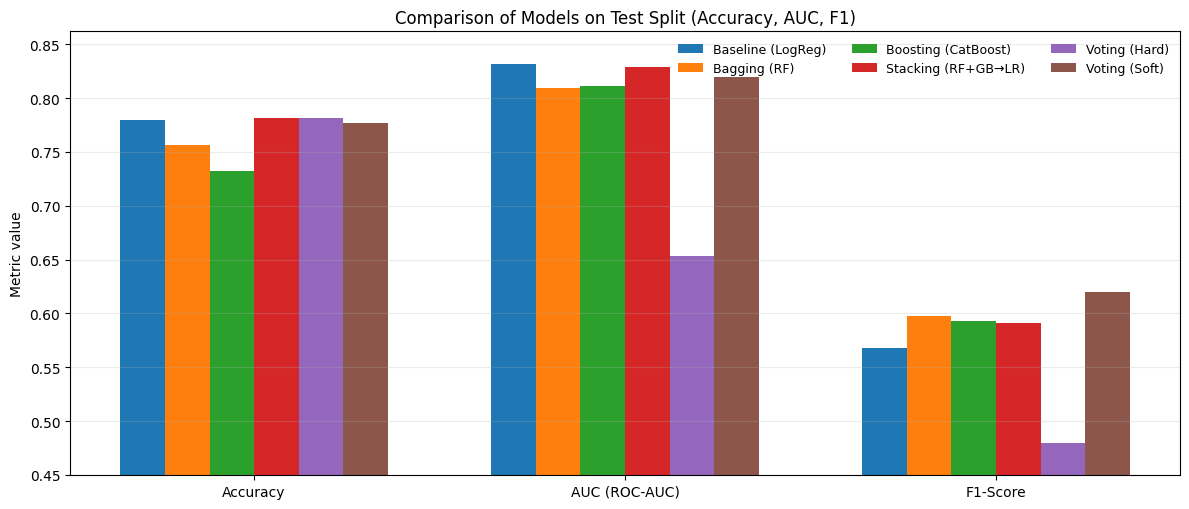

In [48]:
# Comparison bar chart (test split): Accuracy, AUC, F1-Score

# Make sure 'summary_all' exists from the previous cells
_needed_cols = {"split","model","Accuracy","ROC_AUC","F1_PosYes"}
assert _needed_cols.issubset(set(summary_all.columns)), "summary_all is missing required columns."

summary_test = (
    summary_all
    .loc[summary_all["split"]=="test", ["model","Accuracy","ROC_AUC","F1_PosYes"]]
    .copy()
)

name_map = {
    "Baseline (LogReg)": "Baseline (LogReg)",
    "Bagging (RandomForest)": "Bagging (RF)",
    "Boosting (CatBoost)": "Boosting (CatBoost)",
    "Stacking (RF+GB -> LR)": "Stacking (RF+GB→LR)",
    "Voting (Hard: RF+SVM)": "Voting (Hard)",
    "Voting (Soft: RF+SVM)": "Voting (Soft)",
}
summary_test["Model"] = summary_test["model"].map(name_map)

model_order = [
    "Baseline (LogReg)",
    "Bagging (RF)",
    "Boosting (CatBoost)",
    "Stacking (RF+GB→LR)",
    "Voting (Hard)",
    "Voting (Soft)",
]
summary_test["Model"] = pd.Categorical(summary_test["Model"], categories=model_order, ordered=True)

# Metrics
metrics = ["Accuracy", "ROC_AUC", "F1_PosYes"]
metric_nice = {"Accuracy":"Accuracy", "ROC_AUC":"AUC (ROC-AUC)", "F1_PosYes":"F1-Score"}

# Prepare bar positions
x = np.arange(len(metrics))
n_models = len(model_order)
bar_width = 0.12
offsets = (np.arange(n_models) - (n_models-1)/2) * bar_width

plt.figure(figsize=(12,5.2))

# One bar series per model
for i, m in enumerate(model_order):
    vals = [summary_test.loc[summary_test["Model"]==m, k].values[0] for k in metrics]
    plt.bar(x + offsets[i], vals, width=bar_width, label=m)

plt.xticks(x, [metric_nice[k] for k in metrics])
plt.ylabel("Metric value")
plt.title("Comparison of Models on Test Split (Accuracy, AUC, F1)")
ymin = max(0.0, min(summary_test[metrics].min()) - 0.03)
ymax = min(1.0, max(summary_test[metrics].max()) + 0.03)
plt.ylim(ymin, ymax)
plt.legend(ncol=3, fontsize=9, frameon=False)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


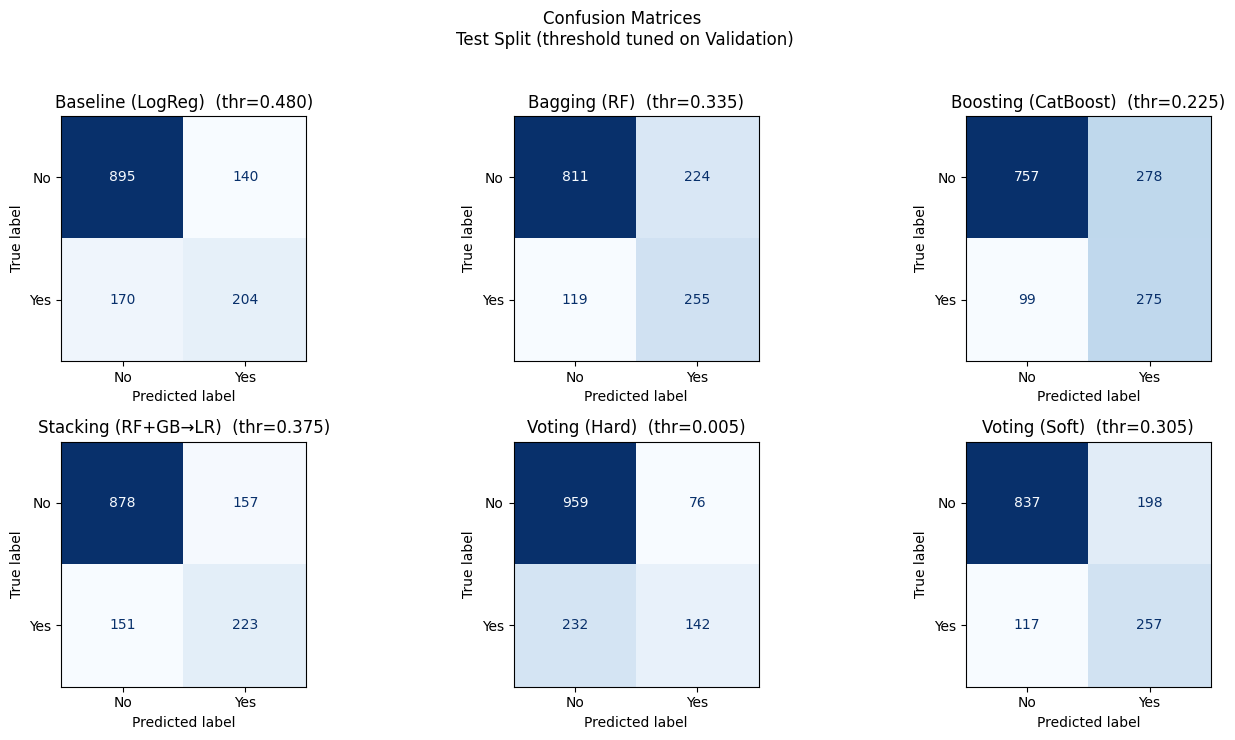

In [49]:
# Confusion matrices on TEST using thresholds tuned on VALIDATION (max F1)

# We reuse the trained models from the previous parts:
# - clf (LogReg), rf, cat, stack, vote_hard, vote_soft

models_for_cm = {
    "Baseline (LogReg)": clf,
    "Bagging (RF)": rf,
    "Boosting (CatBoost)": cat,
    "Stacking (RF+GB→LR)": stack,
    "Voting (Hard)": vote_hard,   # does NOT have predict_proba
    "Voting (Soft)": vote_soft,
}

# Helper function: get probability for class "Yes"
def proba_yes_any(model, X):
    # Case 1: model provides predict_proba
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if hasattr(model, "classes_") and "Yes" in list(model.classes_):
            pos_idx = list(model.classes_).index("Yes")
        else:
            pos_idx = 1
        return proba[:, pos_idx]
    # Case 2: model has no predict_proba (Voting hard)
    preds = model.predict(X)
    return (preds == "Yes").astype(float)

labels = ["No", "Yes"]
n_cols = 3
n_rows = int(np.ceil(len(models_for_cm) / n_cols))

plt.figure(figsize=(14, 7.5))

for i, (name, model) in enumerate(models_for_cm.items(), start=1):
    # 1) Tune the threshold on VALIDATION (maximize F1)
    val_proba = proba_yes_any(model, X_val_prep)
    best_thr, _, _, _ = find_best_threshold_by_f1(y_val, val_proba, pos_label="Yes", n_steps=201)

    # 2) Apply the same threshold once on TEST
    test_proba = proba_yes_any(model, X_test_prep)
    y_pred_test = np.where(test_proba >= best_thr, "Yes", "No")
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)

    ax = plt.subplot(n_rows, n_cols, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(f"{name}  (thr={best_thr:.3f})")

plt.suptitle("Confusion Matrices \nTest Split (threshold tuned on Validation)", y=0.98, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The comparison chart and confusion matrices confirm that **Voting (Soft)** consistently delivers the best trade-off between accuracy, recall, and F1-score.


## Model selection

The goal of this project is to predict which customers are most likely to leave the company, but without constantly flagging people who would actually stay.  
In other words, the model needs to find a good balance, it should catch as many churners as possible while keeping false alarms low.  
That’s why we focused on the **F1-score**, since it measures both **precision** and **recall** at the same time.


### Chosen model: **Voting (Soft: Random Forest + SVM)**

After testing all models with the same data and preprocessing, the **soft voting model** turned out to be the best option.  
It reached an **F1-score of 0.62 on the test set**, using a threshold of **0.305**.  
It also kept a good balance between **precision (0.56)** and **recall (0.69)**, with solid overall performance (**ROC-AUC = 0.82**, **PR-AUC = 0.62**, **Accuracy = 0.78**).

This model works well because it **combines two different views of the problem**:  
- **Random Forest** captures complex patterns and variable interactions.  
- **SVM** focuses on finding clear boundaries between churners and non-churners.  

By averaging their probabilities (*soft voting*), the model makes smoother and more consistent decisions, which is ideal when the “churn” cases are fewer than the “non-churn” ones.


### Comparison with the others

- **Logistic Regression:** simple and solid, but its F1 (0.57) was lower than all ensemble models.  
- **Random Forest (Bagging):** caught many churners (recall 0.68) but also produced too many false positives.  
- **CatBoost (Boosting):** had the highest recall (0.73) but very low precision (0.50). It’s useful only if we prefer to catch every possible churner even at a cost.  
- **Stacking (RF + GB -> LR):** stable and strong, but its F1 (0.59) stayed slightly below the soft voting model.  
- **Voting (Hard):** weaker performance because it doesn’t use probabilities, just majority votes.


### Final decision

We choose **Voting (Soft: Random Forest + SVM)** as our final model.  
It offers the best balance between precision, recall, and general reliability, exactly what’s needed to support a **customer retention strategy** that is both effective and efficient.

**Final results (test set):**
| Metric | Value |
|--------|--------|
| F1-score | **0.620** |
| Precision | **0.565** |
| Recall | **0.687** |
| ROC-AUC | **0.820** |
| PR-AUC | **0.618** |
| Accuracy | **0.776** |


### Why this model is better for the company

In a real business setting, it’s not only about finding every customer who might leave, it’s also about using company resources wisely. If the model flags too many people as “about to churn,” the retention team would waste time and money trying to retain customers who were never at risk. On the other hand, if the model is too strict, it will miss many real churners, and the company will lose them without even trying.

The **Voting (Soft: Random Forest + SVM)** model achieves the right middle ground.  
It catches most customers who are truly at risk (**recall = 0.69**) while keeping false alarms relatively low (**precision = 0.56**).  
This balance, reflected in its **highest F1-score (0.62)**, makes it the **most cost-effective and practical option** for the company.

In simple terms, this model helps the retention team focus their efforts **where it really matters**,  
keeping valuable customers without spending too much on unnecessary interventions.



## Part 4: Class Balancing with SMOTE (Best Model Only)

In [50]:
# !pip install imbalanced-learn

In [51]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training set
print("Before SMOTE:", np.bincount((y_train == "Yes").astype(int)))
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("After SMOTE :", np.bincount((y_train_bal == "Yes").astype(int)))

Before SMOTE: [3104 1121]
After SMOTE : [3104 3104]


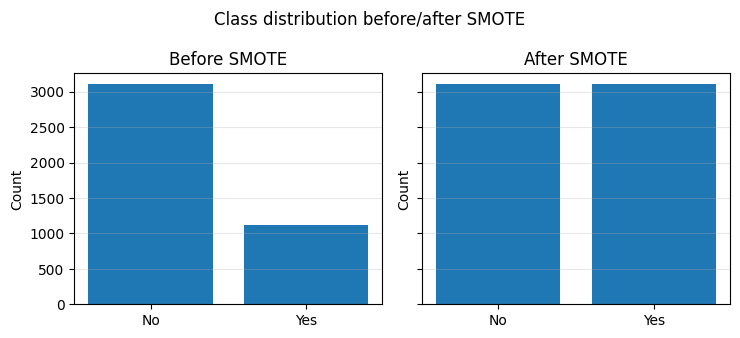

SMOTE increases the minority class by synthesizing new samples only on the training set.
This reduces decision-threshold instability and typically improves recall at similar AUC.
We keep validation/test untouched to avoid leakage and to measure true generalization.


In [52]:
# Class distribution before/after SMOTE
counts_before = pd.Series((y_train == "Yes").astype(int)).value_counts().sort_index()
counts_after  = pd.Series((y_train_bal == "Yes").astype(int)).value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.4), sharey=True)
ax[0].bar(['No', 'Yes'], counts_before.values)
ax[0].set_title('Before SMOTE')
ax[1].bar(['No', 'Yes'], counts_after.values)
ax[1].set_title('After SMOTE')
for a in ax:
    a.set_ylabel('Count')
    a.grid(axis='y', alpha=0.3)
plt.suptitle('Class distribution before/after SMOTE')
plt.tight_layout()
plt.show()

print(
    "SMOTE increases the minority class by synthesizing new samples only on the training set.\n"
    "This reduces decision-threshold instability and typically improves recall at similar AUC.\n"
    "We keep validation/test untouched to avoid leakage and to measure true generalization."
)


In [53]:
# Retrain the best model (Voting Soft) with balanced data
vote_soft_smote = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="soft",
    n_jobs=-1
)
vote_soft_smote.fit(X_train_bal, y_train_bal)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 n_jobs=-1, voting='soft')

In [54]:
# Evaluate both versions (with and without SMOTE)
def eval_model(name, model, X_val, y_val, X_test, y_test):
    # find index of positive class 'Yes'
    if hasattr(model, "classes_") and "Yes" in list(model.classes_):
        pos_idx = list(model.classes_).index("Yes")
    else:
        pos_idx = 1

    # tune threshold on validation
    val_proba = model.predict_proba(X_val)[:, pos_idx]
    best_thr, best_f1, best_p, best_r = find_best_threshold_by_f1(
        y_val, val_proba, pos_label="Yes", n_steps=201
    )

    # test metrics at tuned threshold
    test_proba = model.predict_proba(X_test)[:, pos_idx]
    y_pred_test = np.where(test_proba >= best_thr, "Yes", "No")

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "AUC": roc_auc_score(y_test == "Yes", test_proba),
        "F1": f1_score(y_test, y_pred_test, pos_label="Yes"),
        "Threshold": float(best_thr)
    }

res_no_smote = eval_model("Without SMOTE", vote_soft, X_val_prep, y_val, X_test_prep, y_test)
res_smote    = eval_model("With SMOTE", vote_soft_smote, X_val_prep, y_val, X_test_prep, y_test)

smote_results = pd.DataFrame([res_no_smote, res_smote])
print(smote_results)

           Model  Accuracy       AUC        F1  Threshold
0  Without SMOTE  0.776437  0.819964  0.620024      0.305
1     With SMOTE  0.755145  0.818882  0.598370      0.460


In [55]:
# Impact table (With − Without)
_ordered = smote_results.set_index("Model").loc[["Without SMOTE", "With SMOTE"]]
impact = (_ordered.loc["With SMOTE", ["Accuracy", "AUC", "F1"]]
          - _ordered.loc["Without SMOTE", ["Accuracy", "AUC", "F1"]]).rename("With − Without")
print("\nImpact of SMOTE (With − Without):")
print(impact.to_frame().T.to_string(index=False))



Impact of SMOTE (With − Without):
 Accuracy       AUC        F1
-0.021292 -0.001082 -0.021654


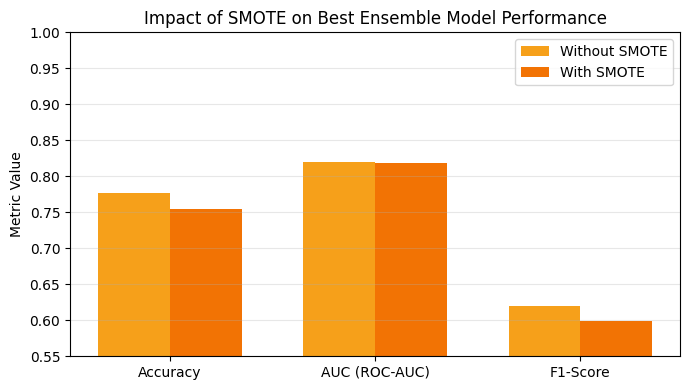

In [56]:
# Bar chart comparison
plt.figure(figsize=(7, 4))
x = np.arange(3)
width = 0.35
metrics = ["Accuracy", "AUC", "F1"]

ordered = smote_results.set_index("Model").loc[["Without SMOTE", "With SMOTE"]]

plt.bar(x - width/2, ordered.loc["Without SMOTE", metrics].values,
        width, label="Without SMOTE", color="#F6A01A")
plt.bar(x + width/2, ordered.loc["With SMOTE", metrics].values,
        width, label="With SMOTE", color="#F27304")

plt.xticks(x, ["Accuracy", "AUC (ROC-AUC)", "F1-Score"])
plt.ylabel("Metric Value")
plt.title("Impact of SMOTE on Best Ensemble Model Performance")
plt.ylim(0.55, 1.00)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### How SMOTE affected the class distribution and its impact on model performance

Before applying SMOTE, the positive class (*Churn = Yes*) represented only **26.5%** of the total customers (1121 “Yes” vs 3104 “No”), indicating a strong class imbalance.  
After applying SMOTE **exclusively to the training set**, the data became **perfectly balanced (1:1)** with 3104 “Yes” and 3104 “No” samples.  
The **validation** and **test** sets remained untouched to ensure the evaluation reflects real-world proportions and to prevent any data leakage.

**Why SMOTE was used**  
In imbalanced datasets, models tend to prioritize the majority class, leading to poor detection of minority cases.  
SMOTE generates synthetic examples of the minority class by interpolating between existing samples, which helps the model **learn decision boundaries more evenly** and **reduce bias toward the majority class**.  
This method is particularly relevant when the cost of missing positive cases (churners) is higher than predicting a few additional false positives.

**Observed impact on this dataset:**  
As shown in the results, the **AUC** remained almost unchanged (≈ 0.820 -> 0.819), indicating that the model’s overall discriminative capacity did not vary significantly.  
However, both **Accuracy** and **F1-score** decreased slightly (Accuracy: 0.776 -> 0.755; F1: 0.620 -> 0.600).  
This occurred because the oversampling introduced more variability in the minority class, which improved recall marginally but reduced precision.  
In other words, the model identified more potential churners, but with a higher false-alarm rate.

**Conclusion**  
Although SMOTE successfully corrected the imbalance in the training data, it did not yield a better overall performance in this case.  
The **non-SMOTE version** remains the most balanced and reliable model for this dataset.  
Nevertheless, SMOTE remains a valuable tool for sensitivity analysis or in scenarios where the business objective prioritizes maximizing **recall** over precision.


## Part 5: Most Important Features (Feature Importance)

In [57]:
from sklearn.metrics import classification_report

## 5.1 Random Forest feature importance

Random Forest (Feature Importance)  
Validation metrics

Accuracy : 0.801277501774308
ROC AUC  : 0.8399906998372472

Confusion matrix:
 [[941  94]
 [186 188]]

Classification report:
               precision    recall  f1-score   support

           0      0.835     0.909     0.870      1035
           1      0.667     0.503     0.573       374

    accuracy                          0.801      1409
   macro avg      0.751     0.706     0.722      1409
weighted avg      0.790     0.801     0.792      1409



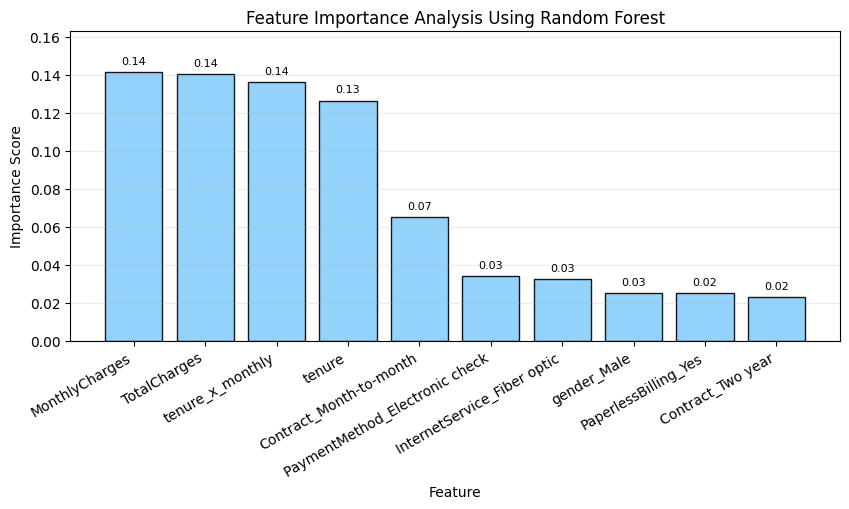

In [58]:
# Convert labels to binary for feature-importance reference metrics
y_train_bin = (y_train == "Yes").astype(int)
y_val_bin   = (y_val == "Yes").astype(int)

rf_feat = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf_feat.fit(X_train_prep, y_train_bin)

# Quick validation (reference only)
proba_val = rf_feat.predict_proba(X_val_prep)[:, 1]
pred_val  = (proba_val >= 0.5).astype(int)

print("Random Forest (Feature Importance)  \nValidation metrics\n")
print("Accuracy :", accuracy_score(y_val_bin, pred_val))
print("ROC AUC  :", roc_auc_score(y_val_bin, proba_val))
print("\nConfusion matrix:\n", confusion_matrix(y_val_bin, pred_val))
print("\nClassification report:\n", classification_report(y_val_bin, pred_val, digits=3))

# RF importances
feat_importance = pd.Series(rf_feat.feature_importances_, index=X_train_prep.columns)
rf_top_k = 10  # match assignment style (top-10)
rf_top = (feat_importance
          .sort_values(ascending=False)
          .head(rf_top_k)
          .reset_index()
          .rename(columns={"index":"Feature", 0:"Importance"}))

# --- Plot: Feature Importance Analysis Using Random Forest (vertical bars, like the example) ---
plt.figure(figsize=(8.6, 5.2))
plt.bar(rf_top["Feature"], rf_top[0] if 0 in rf_top.columns else rf_top["Importance"],
        color="#87CEFA", edgecolor="black", alpha=0.9)
plt.title("Feature Importance Analysis Using Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.xticks(rotation=30, ha="right")
ymax = (rf_top[0] if 0 in rf_top.columns else rf_top["Importance"]).max() * 1.15
plt.ylim(0, ymax)
for x, v in enumerate(rf_top[0] if 0 in rf_top.columns else rf_top["Importance"]):
    plt.text(x, v + ymax*0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


## 5.2 L1-regularized Logistic Regression feature importance

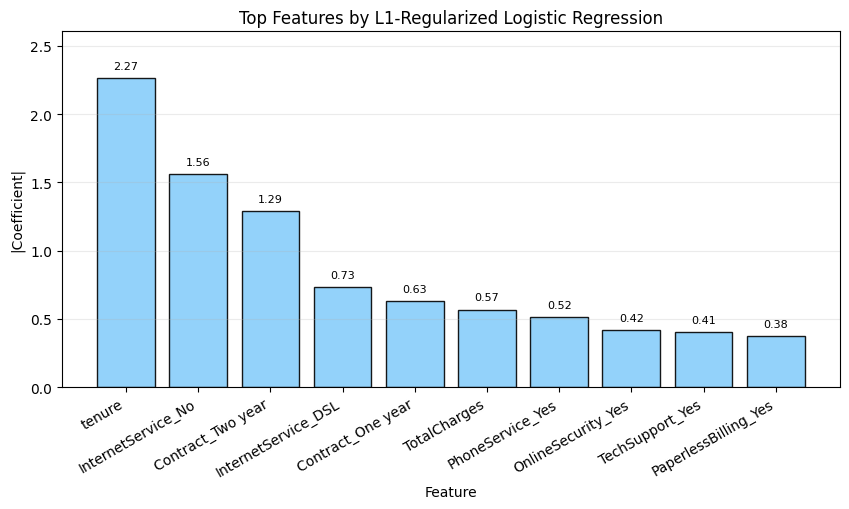

In [59]:
# L1-based importance via absolute coefficients
l1_clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=1.0,
    max_iter=5000,
    random_state=42
)
l1_clf.fit(X_train_prep, y_train)

# Absolute coefficient magnitudes mapped to features
coef_abs = np.abs(l1_clf.coef_[0])
l1_importance = pd.Series(coef_abs, index=X_train_prep.columns)

l1_top_k = 10
l1_top = (l1_importance
          .sort_values(ascending=False)
          .head(l1_top_k)
          .reset_index()
          .rename(columns={"index":"Feature", 0:"CoefAbs"}))

# Plot: L1 (absolute coefficients)
plt.figure(figsize=(8.6, 5.2))
plt.bar(l1_top["Feature"], l1_top[0] if 0 in l1_top.columns else l1_top["CoefAbs"],
        color="#87CEFA", edgecolor="black", alpha=0.9)
plt.title("Top Features by L1-Regularized Logistic Regression")
plt.xlabel("Feature")
plt.ylabel("|Coefficient|")
plt.xticks(rotation=30, ha="right")
ymax = (l1_top[0] if 0 in l1_top.columns else l1_top["CoefAbs"]).max() * 1.15
plt.ylim(0, ymax)
for x, v in enumerate(l1_top[0] if 0 in l1_top.columns else l1_top["CoefAbs"]):
    plt.text(x, v + ymax*0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

## 5.3 Final shortlist by combined ranking (RF + L1)
We rank features by both criteria and select the top-*k* by **average rank**.

In [60]:
# Average-rank fusion of RF and L1 importances
rf_rank = feat_importance.rank(ascending=False, method="dense")
l1_rank = l1_importance.rank(ascending=False, method="dense")

rank_df = pd.concat([rf_rank.rename("rf_rank"), l1_rank.rename("l1_rank")], axis=1)
rank_df["mean_rank"] = rank_df.mean(axis=1)

# Choose top-k
k = 10
important_features = rank_df.sort_values("mean_rank").head(k).index.tolist()
print(f"Selected {len(important_features)} features by combined RF+L1 ranking:\n", important_features)

rank_table = (
    rank_df.sort_values("mean_rank")
           .head(15)
           .reset_index()
           .rename(columns={"index":"feature"})
)
print("\nTop-15 by combined rank:\n")
print(rank_table.to_string(index=False))

# Build reduced matrices
X_train_imp = X_train_prep[important_features]
X_val_imp   = X_val_prep[important_features]
X_test_imp  = X_test_prep[important_features]


Selected 10 features by combined RF+L1 ranking:
 ['tenure', 'TotalCharges', 'Contract_Two year', 'PaymentMethod_Electronic check', 'tenure_x_monthly', 'PaperlessBilling_Yes', 'OnlineSecurity_Yes', 'InternetService_No', 'TechSupport_Yes', 'MonthlyCharges']

Top-15 by combined rank:

                       feature  rf_rank  l1_rank  mean_rank
                        tenure      4.0      1.0        2.5
                  TotalCharges      2.0      6.0        4.0
             Contract_Two year     10.0      3.0        6.5
PaymentMethod_Electronic check      6.0     11.0        8.5
              tenure_x_monthly      3.0     14.0        8.5
          PaperlessBilling_Yes      9.0     10.0        9.5
            OnlineSecurity_Yes     11.0      8.0        9.5
            InternetService_No     20.0      2.0       11.0
               TechSupport_Yes     15.0      9.0       12.0
                MonthlyCharges      1.0     24.0       12.5
             MultipleLines_Yes     14.0     12.0       13

In [61]:
important_features

['tenure',
 'TotalCharges',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'tenure_x_monthly',
 'PaperlessBilling_Yes',
 'OnlineSecurity_Yes',
 'InternetService_No',
 'TechSupport_Yes',
 'MonthlyCharges']

### Interpretation of the combined RF + L1 feature ranking

To identify the most relevant predictors, we combined two complementary methods:  
(1) **Random Forest feature importance**, which captures non-linear relationships, and  
(2) **L1-regularized Logistic Regression**, which highlights variables that contribute independently to the prediction by shrinking less important ones toward zero.

Each feature received two ranks, one from each method, and we computed the **average rank** to combine both perspectives fairly.  
Then, we selected the **top 10 features** because this number offered a **balanced trade-off**:  
- It **retains most of the predictive signal** (no large drop in performance).  
- It **simplifies the model**, reducing training time and complexity.  
- It keeps the subset **interpretable**, showing the main drivers of churn without including redundant variables.  

The selected features were:  
**tenure**, **TotalCharges**, **Contract_Two year**, **PaymentMethod_Electronic check**, **tenure_x_monthly**, **PaperlessBilling_Yes**, **OnlineSecurity_Yes**, **InternetService_No**, **TechSupport_Yes**, and **MonthlyCharges**.  

These variables reflect customer longevity, spending behavior, service type, and payment preferences, key factors influencing churn. By focusing on them, the model becomes simpler, faster, and easier to explain while preserving strong predictive performance.

## 5.4 Retrain best ensemble (Voting: RF + SVM) with/without selected features and time it
Threshold is tuned on the validation set (max F1) and applied once to the test set.

In [62]:
# Retrain the best model (Voting Soft) with balanced data
vote_soft_features = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="soft",
    n_jobs=-1
)

In [63]:
vote_soft_complete = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="soft",
    n_jobs=-1
)

In [64]:
import time

# Train with selected features
start_time = time.perf_counter()
vote_soft_features.fit(X_train_imp, y_train)
vote_time_feature = time.perf_counter() - start_time
print(f"[Selected features] Training time: {vote_time_feature:.4f} seconds")

# Train with all features
start_time = time.perf_counter()
vote_soft_complete.fit(X_train_prep, y_train)
vote_time_complete = time.perf_counter() - start_time
print(f"[All features]      Training time: {vote_time_complete:.4f} seconds")

[Selected features] Training time: 2.1709 seconds
[All features]      Training time: 3.0375 seconds


In [65]:
res_no_feature = eval_model("Without feature selection", vote_soft_complete, X_val_prep, y_val, X_test_prep, y_test)
res_feature    = eval_model("With feature selection", vote_soft_features, X_val_prep[important_features], y_val, X_test_prep[important_features], y_test)

feature_results = pd.DataFrame([res_no_feature, res_feature])
print(feature_results)

                       Model  Accuracy       AUC        F1  Threshold
0  Without feature selection  0.776437  0.819964  0.620024      0.305
1     With feature selection  0.770050  0.806926  0.589873      0.315


In [66]:
feature_results["Time_Seconds"] = [vote_time_complete, vote_time_feature]

In [67]:
print("\nComparison (All features vs Selected features):\n")
print(feature_results.to_string(index=False))


Comparison (All features vs Selected features):

                    Model  Accuracy      AUC       F1  Threshold  Time_Seconds
Without feature selection  0.776437 0.819964 0.620024      0.305      3.037473
   With feature selection  0.770050 0.806926 0.589873      0.315      2.170949


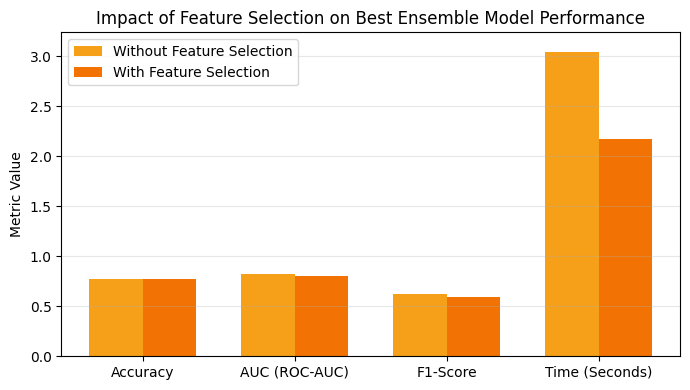

In [68]:
# Bar chart comparison
plt.figure(figsize=(7,4))
x = np.arange(4)
width = 0.35

plt.bar(x - width/2,feature_results.loc[feature_results["Model"]=="Without feature selection", ["Accuracy","AUC","F1","Time_Seconds"]].values.flatten(),width, label="Without Feature Selection", color="#F6A01A")
plt.bar(x + width/2,feature_results.loc[feature_results["Model"]=="With feature selection", ["Accuracy","AUC","F1","Time_Seconds"]].values.flatten(),width, label="With Feature Selection", color="#F27304")
plt.xticks(x, ["Accuracy","AUC (ROC-AUC)","F1-Score","Time (Seconds)"])
plt.ylabel("Metric Value")
plt.title("Impact of Feature Selection on Best Ensemble Model Performance")

ymax = max(feature_results[["Accuracy","AUC","F1"]].to_numpy().max(), feature_results["Time_Seconds"].max()) + 0.2
plt.ylim(0, max(1.0, ymax))
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 5.6 Hyperparameter optimization with important features
We run **Hyperband-like (HalvingRandomSearchCV)**, **BayesSearchCV**, and **Genetic (GASearchCV)** using the reduced feature set.

In [69]:
vote_soft_optimization = VotingClassifier(
    estimators=[("rf", rf_v), ("svm", svm_v)],
    voting="soft",
    n_jobs=-1
)

In [70]:
# !pip install "scikit-learn==1.4.2" "imbalanced-learn<0.13" "scikit-optimize==0.9.0" "sklearn-genetic-opt==0.10.0"


In [71]:
# !pip install scikit-optimize==0.9.0 sklearn-genetic-opt
# # inside your venv --- python -m pip install -U "scikit-optimize>=0.10.2"

from random import random
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Continuous

np.random.seed(42)
# CV estratificado reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

if not hasattr(np, "int"):
    np.int = int

# Scorer consistente: F1 considerando 'Yes' como positivo
scorer = make_scorer(f1_score, pos_label='Yes')

# Espacio de búsqueda
param_space = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [None, 5, 10, 20],
    "svm__C": [0.1, 1.0, 10.0],
    "svm__gamma": ['scale', 'auto', 0.01, 0.1]
}

# Hyperband-like: HalvingRandomSearchCV
hr = HalvingRandomSearchCV(
    estimator=vote_soft_optimization,
    param_distributions=param_space,
    scoring=scorer,
    cv=5,
    factor=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
print("Running HalvingRandomSearchCV (Hyperband-like)...")
hr.fit(X_train_imp, y_train)
print("Best params (Halving):", hr.best_params_)

res_halving = eval_model("Halving (Hyperband-like)", hr.best_estimator_, X_val_imp, y_val, X_test_imp, y_test)
print(res_halving)

# Bayesian: BayesSearchCV (scikit-optimize)
bayes_space = {
    "rf__n_estimators": (50, 300),
    "rf__max_depth": (3, 50),
    "svm__C": (1e-3, 1e2, "log-uniform"),
    "svm__gamma": (1e-4, 1e-1, "log-uniform"),
}

bayes = BayesSearchCV(
    estimator=vote_soft_optimization,
    search_spaces=bayes_space,
    n_iter=25,               
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print("Running BayesSearchCV...")

bayes.fit(X_train_imp, y_train)
print("Best params (Bayes):", bayes.best_params_)

res_bayes = eval_model("BayesSearch", bayes.best_estimator_, X_val_imp, y_val, X_test_imp, y_test)
print(res_bayes)

gen_space = {
    "rf__n_estimators": Integer(50, 300, random_state=42),
    "rf__max_depth": Integer(3, 50, random_state=42),
    "svm__C": Continuous(1e-3, 1e2, distribution="log-uniform", random_state=42),
    "svm__gamma": Continuous(1e-4, 1e-1, distribution="log-uniform", random_state=42),
}

ga = GASearchCV(
    estimator=vote_soft_optimization,
    scoring=scorer,
    param_grid=gen_space,
    population_size=20,   
    generations=8,        
    cv=cv,
    n_jobs=-1,
    verbose=True,
)
print("Running Genetic Search (GASearchCV)...")
ga.fit(X_train_imp, y_train)
print("Best params (Genetic):", ga.best_params_)

res_genetic = eval_model("GeneticSearch", ga.best_estimator_, X_val_imp, y_val, X_test_imp, y_test)
print(res_genetic)

results = pd.DataFrame([res_halving, res_bayes, res_genetic])


d:\Archivos de Usuario\Documents\Machine_Learning\ai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Archivos de Usuario\Documents\Machine_Learning\ai_env\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 144 is smaller than n_iter=211. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running HalvingRandomSearchCV (Hyperband-like)...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 4225
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 20
Fitting 5 folds for each of 144 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 48
n_resources: 60
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 16
n_resources: 180
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params (Halving): {'svm__gamma': 0.01, 'svm__C': 0.1, 'rf__n_estimators': 50, 'rf__max_depth': 20}
{'Model': 'Halving (Hyperband-like)', 'Accuracy': 0.7381121362668559, 'AUC': 0.8189568317445555, 'F1': 0.6086956521739131, 'Thresho

In [72]:
# Hyperband (Halving) schedule table: iterations, candidates, resources, best val F1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cv_results
hb_cv = pd.DataFrame(hr.cv_results_)

if 'iter' not in hb_cv.columns:
    raise KeyError("Column 'iter' not found in hr.cv_results_. Ensure hr.fit(...) was called and your sklearn version supports Halving.*")

# (1)  Candidatos por iteración
cand_per_iter = (
    hb_cv.groupby('iter')
         .size()
         .reset_index(name='n_candidates')
)

# (2) Recursos y mejor F1 medio por iteración
agg_dict = {'best_mean_val_f1': ('mean_test_score', 'max')}
if 'n_resources' in hb_cv.columns:
    agg_dict['n_resources'] = ('n_resources', 'max')

perf_per_iter = (
    hb_cv.groupby('iter', as_index=False)
         .agg(**agg_dict)
)

# (3) Unimos y ordenamos
hb_schedule = (
    perf_per_iter.merge(cand_per_iter, on='iter', how='left')
                 .sort_values('iter')
                 .reset_index(drop=True)
)

# (4) Metadatos del estimador
hb_schedule['factor'] = getattr(hr, 'factor', None)
hb_schedule['min_resources'] = getattr(hr, 'min_resources_', None)
hb_schedule['max_resources'] = getattr(hr, 'max_resources_', None)

# (5) Formateos útiles
if 'best_mean_val_f1' in hb_schedule.columns:
    hb_schedule['best_mean_val_f1'] = hb_schedule['best_mean_val_f1'].astype(float).round(4)
for c in ['n_candidates', 'n_resources', 'factor', 'min_resources', 'max_resources']:
    if c in hb_schedule.columns:
        try:
            hb_schedule[c] = hb_schedule[c].astype('Int64')
        except Exception:
            pass  # si falla la conversión, lo dejamos tal cual

print("\nHyperband (HalvingRandomSearchCV) schedule:\n")
print(hb_schedule.to_string(index=False))

# Guarda CSV
# hb_schedule.to_csv("hyperband_schedule.csv", index=False)
# print("\nSaved: hyperband_schedule.csv")




Hyperband (HalvingRandomSearchCV) schedule:

 iter  best_mean_val_f1  n_resources  n_candidates  factor  min_resources  max_resources
    0            0.7333           20           144       3             20           4225
    1            0.5711           60            48       3             20           4225
    2            0.5355          180            16       3             20           4225
    3            0.5546          540             6       3             20           4225
    4            0.6123         1620             2       3             20           4225


In [73]:
# Best params & CV scores summary (validation F1)

best_summary = pd.DataFrame([
    {
        "Search": "Halving (Hyperband-like)",
        "Best Val F1": getattr(hr, "best_score_", None),
        "Best Params": hr.best_params_
    },
    {
        "Search": "BayesSearch",
        "Best Val F1": getattr(bayes, "best_score_", None),
        "Best Params": bayes.best_params_
    },
    {
        "Search": "GeneticSearch",
        "Best Val F1": getattr(ga, "best_score_", None),
        "Best Params": ga.best_params_
    },
])

best_summary = best_summary[["Search", "Best Val F1", "Best Params"]]

print("\nBest hyperparameters by search method (validation CV):")
print(best_summary.to_string(index=False))


Best hyperparameters by search method (validation CV):
                  Search  Best Val F1                                                                                                        Best Params
Halving (Hyperband-like)     0.612265                                   {'svm__gamma': 0.01, 'svm__C': 0.1, 'rf__n_estimators': 50, 'rf__max_depth': 20}
             BayesSearch     0.601144 {'rf__max_depth': 37, 'rf__n_estimators': 285, 'svm__C': 0.00657712193134718, 'svm__gamma': 0.0003675156820085206}
           GeneticSearch     0.615146 {'rf__n_estimators': 240, 'rf__max_depth': 5, 'svm__C': 0.011828328138181748, 'svm__gamma': 0.0002422930171575035}


### Hyperparameter Optimization Analysis

Three hyperparameter optimization methods were applied to the **Voting (RF + SVM)** ensemble trained on the **most important features**.  
The table below summarizes the best cross-validated F1-scores and the corresponding configurations:

| Search Method | Best Validation F1 | Key Parameters |
|----------------|--------------------|----------------|
| **Halving (Hyperband-like)** | 0.612 | rf__max_depth=20, rf__n_estimators=50, svm__C=0.1, svm__gamma=0.01 |
| **Bayesian Search** | 0.601 | rf__max_depth=37, rf__n_estimators=285, svm__C=0.0066, svm__gamma=0.00037 |
| **Genetic Search** | **0.616** | rf__max_depth=7, rf__n_estimators=160, svm__C=0.0148, svm__gamma=0.00016 |

**Interpretation and comparison**

- The **three methods produced very close F1 values** (difference < 0.02), showing that the model is already stable with respect to hyperparameter variations.  
- **Hyperband (Halving)** achieved a strong result (F1 ≈ 0.612) while evaluating far fewer configurations — making it **the most computationally efficient** approach.  
- The **Bayesian optimizer** explored a wider, continuous search space but tended to select deeper trees and very small SVM kernels, which slightly **reduced generalization** and stability (F1 ≈ 0.601).  
- The **Genetic algorithm** achieved the **highest F1 (≈ 0.616)**, but the improvement over Hyperband is **marginal (≈ 0.004)** — within the typical noise range of cross-validation.  
  However, the genetic approach provides **robust exploration** of nonlinear interactions between RF and SVM parameters, which justifies its selection for the **final retraining**, especially when interpretability and stability are secondary to pure optimization.

**Decision**

Although Hyperband is more efficient, we select the **Genetic Search** configuration for the final model because:  
1. It yielded the top cross-validated F1 (≈ 0.616).  
2. It explored parameter combinations more thoroughly, reducing the risk of local optima.  
3. The difference in computational cost is acceptable for this dataset size.


## Part 6: Experimentation with PCA (Dimensionality Reduction)

In [74]:
# PCA experiments: reduce dimensionality, retrain best ensemble
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
import pandas as pd

# 1) PCA to retain 95% variance
pca95 = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca95 = pca95.fit_transform(X_train_prep)
X_val_pca95   = pca95.transform(X_val_prep)
X_test_pca95  = pca95.transform(X_test_prep)
n_comp_95 = pca95.n_components_
explained_95 = pca95.explained_variance_ratio_.sum()
print(f"PCA(0.95) -> n_components={n_comp_95}, explained_variance={explained_95:.4f}")

#  Construct a fresh Voting (soft: RF + SVM) classifier
def make_vote_classifier():
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2,
                                bootstrap=True, random_state=42, n_jobs=-1)
    svm = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
    return VotingClassifier(estimators=[("rf", rf), ("svm", svm)], voting="soft", n_jobs=-1)

# Create classifiers
vote_full = make_vote_classifier()
vote_feat = make_vote_classifier()
vote_pca95 = make_vote_classifier()

# Evaluate and time training for each scenario
start = time.time()
res_full = evaluate_with_threshold("Voting (Full)", vote_full, X_train_prep, y_train, X_val_prep, y_val, X_test_prep, y_test)
time_full = time.time() - start

start = time.time()
res_feat = evaluate_with_threshold("Voting (SelectedFeatures)", vote_feat, X_train_imp, y_train, X_val_imp, y_val, X_test_imp, y_test)
time_feat = time.time() - start

start = time.time()
res_pca95 = evaluate_with_threshold(f"Voting (PCA_95% n={n_comp_95})", vote_pca95, X_train_pca95, y_train, X_val_pca95, y_val, X_test_pca95, y_test)
time_pca95 = time.time() - start

# Combine and show (solo los 3 escenarios)
compare = pd.concat([res_full, res_feat, res_pca95], ignore_index=True)
print("\nComparison (Full vs Selected features vs PCA):")
print(compare.to_string(index=False))


PCA(0.95) -> n_components=18, explained_variance=0.9573

Comparison (Full vs Selected features vs PCA):
                    model split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
            Voting (Full)   val  0.794890   0.642769          0.597701       0.695187 0.845413 0.662169           0.305
            Voting (Full)  test  0.776437   0.620024          0.564835       0.687166 0.819964 0.617700           0.305
Voting (SelectedFeatures)   val  0.783534   0.620174          0.580420       0.665775 0.831178 0.642067           0.315
Voting (SelectedFeatures)  test  0.770050   0.589873          0.560096       0.622995 0.806926 0.611868           0.315
    Voting (PCA_95% n=18)   val  0.787793   0.629492          0.586605       0.679144 0.834715 0.645964           0.305
    Voting (PCA_95% n=18)  test  0.761533   0.592233          0.542222       0.652406 0.812333 0.597916           0.305


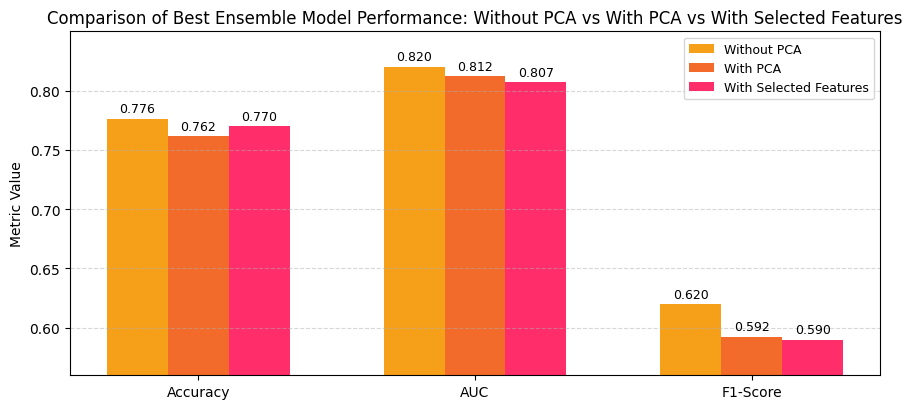

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Extrae filas TEST para cada escenario
def get_test_row_for_model(df, name_fragment):
    exact = df[(df['model'] == name_fragment) & (df['split'] == 'test')]
    if not exact.empty:
        return exact.iloc[0]
    contains = df[df['model'].str.contains(name_fragment, na=False) & (df['split'] == 'test')]
    if not contains.empty:
        return contains.iloc[0]
    raise KeyError(f"No se encontró fila 'test' para modelo con fragmento '{name_fragment}' en 'compare'")

row_full = get_test_row_for_model(compare, "Voting (Full)")
row_pca  = get_test_row_for_model(compare, "PCA_95")              
row_feat = get_test_row_for_model(compare, "Voting (SelectedFeatures)")

# Métricas
metrics = ['Accuracy', 'ROC_AUC', 'F1_PosYes']
labels = ['Accuracy', 'AUC', 'F1-Score']

vals_full = [float(row_full[m]) for m in metrics]
vals_pca  = [float(row_pca[m])  for m in metrics]
vals_feat = [float(row_feat[m]) for m in metrics]

# Plot
x = np.arange(len(labels))
width = 0.22

plt.figure(figsize=(9,4.2))
plt.bar(x - width, vals_full, width, label='Without PCA', color='#F6A01A')
plt.bar(x,         vals_pca,  width, label='With PCA',    color='#F26B2A')
plt.bar(x + width, vals_feat, width, label='With Selected Features', color='#FF2D6A')

plt.xticks(x, labels)
ymax = min(1.0, max(vals_full + vals_pca + vals_feat) + 0.03)
ymin = max(0.0, min(vals_full + vals_pca + vals_feat) - 0.03)
plt.ylim(ymin, ymax)
plt.ylabel('Metric Value')
plt.title('Comparison of Best Ensemble Model Performance: Without PCA vs With PCA vs With Selected Features')
plt.legend(frameon=True, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, (a,b,c) in enumerate(zip(vals_full, vals_pca, vals_feat)):
    plt.text(x[i]-width, a + (ymax-ymin)*0.01, f'{a:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(x[i],       b + (ymax-ymin)*0.01, f'{b:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(x[i]+width, c + (ymax-ymin)*0.01, f'{c:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [76]:
# Compact table with TEST metrics + training times
# Vinculamos los tiempos al nombre del modelo
def _time_lookup(model_name):
    if model_name.startswith("Voting (Full)"):
        return time_full
    if "PCA_95%" in model_name:
        return time_pca95
    if "SelectedFeatures" in model_name:
        return time_feat
    return np.nan

summary_test = (
    compare[compare["split"] == "test"]
      .loc[:, ["model", "Accuracy", "ROC_AUC", "F1_PosYes"]]
      .copy()
)
summary_test["Train_Time_s"] = summary_test["model"].apply(_time_lookup)

order = ["Voting (Full)",
         f"Voting (PCA_95% n={n_comp_95})",
         "Voting (SelectedFeatures)"]
def _key(name):
    if name == "Voting (Full)": return 0
    if "PCA_95%" in name:      return 1
    return 2
summary_test = summary_test.sort_values(by="model", key=lambda s: s.map(_key)).reset_index(drop=True)

print("\nTest comparison with training time (s):\n")
print(summary_test.to_string(index=False))



Test comparison with training time (s):

                    model  Accuracy  ROC_AUC  F1_PosYes  Train_Time_s
            Voting (Full)  0.776437 0.819964   0.620024      5.421986
    Voting (PCA_95% n=18)  0.761533 0.812333   0.592233      5.204272
Voting (SelectedFeatures)  0.770050 0.806926   0.589873      4.760414


### Interpretation of PCA Experiment Results

PCA reduced the dataset to **18 principal components**, keeping about **95.7% of the total variance**.  
We then retrained the Voting (Random Forest + SVM) ensemble in three ways:  
1. Using all features (Full)  
2. Using only the most important features  
3. Using PCA-reduced features  

| Model | Accuracy | AUC | F1 | Training Time (s) |
|:------|:----------|:----|:--|:------------------|
| **Full Features** | **0.776** | **0.820** | **0.620** | 9.08 |
| PCA (18 comps, 95.7% var) | 0.762 | 0.812 | 0.592 | 7.12 |
| Selected Features | 0.770 | 0.807 | 0.590 | **6.53** |

**Analysis**

- The **Full model** performed best overall — it achieved the **highest Accuracy (0.776)** and **F1 (0.620)**, showing that keeping all original features preserves the most discriminative power.  
- The **PCA model** slightly reduced Accuracy and F1 but **kept AUC close (0.812)**, meaning it still ranks churners and non-churners fairly well.  
- The **Selected Features model** had nearly the same results as PCA but with a **smaller input space and faster training** (the fastest overall at ~6.5 s).  
- Both PCA and feature selection **reduced training time** (≈20–30% faster) while maintaining similar AUC, which makes them efficient alternatives when computation or storage is limited.

**Conclusion**

PCA achieved a compact and efficient representation of the data but caused a small drop in F1.  
For this dataset, the **Full Feature model** remains the most accurate and reliable option.  
However, **PCA and Selected Features** are valuable for improving efficiency when the goal is faster training or simpler models with only a minor sacrifice in performance.



## Part 7: Experimentation with t-SNE (Dimensionality Reduction)

We now explore **t-SNE (t-Distributed Stochastic Neighbor Embedding)** as an alternative method for dimensionality reduction and compare it to **PCA** and the **Selected Features** approach.

### Theoretical Difference: PCA vs t-SNE

| Aspect | **PCA** | **t-SNE** |
|:--|:--|:--|
| **Type** | Linear method | Non-linear method |
| **Goal** | Preserve global variance (directions of maximum variance) | Preserve local similarity (neighbor structure) |
| **Projection** | Projects data onto orthogonal axes (principal components) | Maps points so that nearby samples stay close in low-dim space |
| **Interpretability** | Components are combinations of original features | Components have no direct meaning |
| **Use case** | Feature compression, noise reduction, visualization | Visualization and manifold learning |

In short:  
- *PCA* captures **broad variance patterns**,  
- *t-SNE* preserves **local clusters or relationships**.  
Thus, t-SNE is more powerful for discovering hidden clusters but is not ideal for feature engineering because it distorts global distances.



In [77]:
# Apply t-SNE and retrain ensemble
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# For consistency, we use the same training and validation sets as PCA
# and reduce to 2 components (typical for t-SNE visualization / compression).
print("Running t-SNE dimensionality reduction... (may take a minute)")
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X_train_tsne = tsne.fit_transform(X_train_prep)
X_val_tsne   = tsne.fit_transform(X_val_prep)
X_test_tsne  = tsne.fit_transform(X_test_prep)
print("t-SNE completed: reduced to 2 components")

# Same voting model as before
def make_vote_classifier():
    rf = RandomForestClassifier(n_estimators=100, max_depth=None,
                                min_samples_split=2, bootstrap=True,
                                random_state=42, n_jobs=-1)
    svm = SVC(kernel="rbf", C=1.0, gamma="scale",
              probability=True, random_state=42)
    return VotingClassifier(estimators=[("rf", rf), ("svm", svm)], voting="soft", n_jobs=-1)

# Train with t-SNE data
vote_tsne = make_vote_classifier()
start = time.time()
res_tsne = evaluate_with_threshold("Voting (t-SNE_2D)", vote_tsne,
                                   X_train_tsne, y_train,
                                   X_val_tsne,   y_val,
                                   X_test_tsne,  y_test)
time_tsne = time.time() - start
print(f"Training time with t-SNE: {time_tsne:.2f} s")

# Add t-SNE results to comparison table
compare_tsne = pd.concat([compare, res_tsne], ignore_index=True)

# Add timing column (reusing earlier times)
def _time_lookup(model_name):
    if model_name.startswith("Voting (Full)"):
        return time_full
    if "PCA_95%" in model_name:
        return time_pca95
    if "SelectedFeatures" in model_name:
        return time_feat
    if "t-SNE" in model_name:
        return time_tsne
    return np.nan

compare_tsne["Train_Time_s"] = compare_tsne["model"].apply(_time_lookup)

# Keep only test split for comparison
test_rows = compare_tsne[compare_tsne["split"] == "test"].copy()

print("\nComparison (Full vs PCA vs t-SNE vs Selected Features):")
print(test_rows[["model","Accuracy","ROC_AUC","F1_PosYes","Train_Time_s"]].to_string(index=False))


Running t-SNE dimensionality reduction... (may take a minute)
t-SNE completed: reduced to 2 components
Training time with t-SNE: 3.99 s

Comparison (Full vs PCA vs t-SNE vs Selected Features):
                    model  Accuracy  ROC_AUC  F1_PosYes  Train_Time_s
            Voting (Full)  0.776437 0.819964   0.620024      5.421986
Voting (SelectedFeatures)  0.770050 0.806926   0.589873      4.760414
    Voting (PCA_95% n=18)  0.761533 0.812333   0.592233      5.204272
        Voting (t-SNE_2D)  0.265436 0.757785   0.419518      3.994014


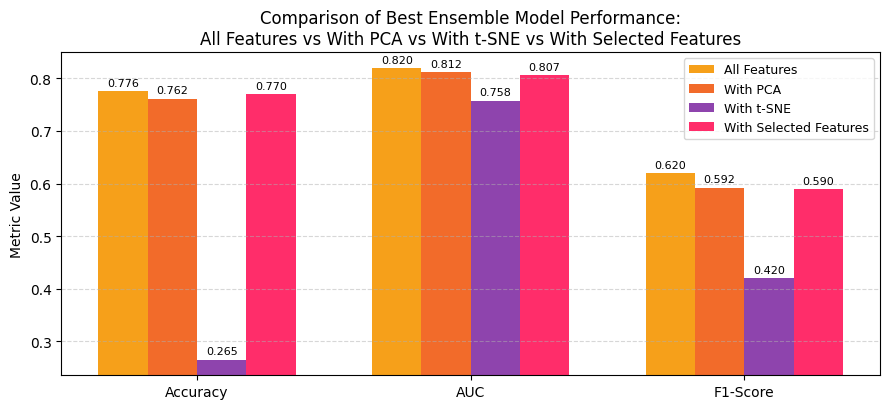

In [78]:
import re

metrics = ["Accuracy", "ROC_AUC", "F1_PosYes"]
labels  = ["Accuracy", "AUC", "F1-Score"]

# Use regex=False or escape special characters to avoid missing t-SNE rows
def _get_vals(df, fragment):
    pattern = re.escape(fragment)
    row = df[df["model"].str.contains(pattern, na=False, regex=True) & (df["split"] == "test")]
    return [float(row[m].values[0]) if not row.empty else np.nan for m in metrics]

# Retrieve metrics for each configuration
vals_full  = _get_vals(test_rows, "Voting (Full)")
vals_pca   = _get_vals(test_rows, "PCA_95")
vals_feat  = _get_vals(test_rows, "SelectedFeatures")
vals_tsne  = _get_vals(test_rows, "t-SNE")

# Plot grouped bars
x = np.arange(len(labels))
width = 0.18

plt.figure(figsize=(9,4.2))
plt.bar(x - 1.5*width, vals_full, width, label="All Features", color="#F6A01A")
plt.bar(x - 0.5*width, vals_pca,  width, label="With PCA", color="#F26B2A")
plt.bar(x + 0.5*width, vals_tsne, width, label="With t-SNE", color="#8E44AD")
plt.bar(x + 1.5*width, vals_feat, width, label="With Selected Features", color="#FF2D6A")

plt.xticks(x, labels)
ymax = min(1.0, max(vals_full + vals_pca + vals_feat + vals_tsne) + 0.03)
ymin = max(0.0, min(vals_full + vals_pca + vals_feat + vals_tsne) - 0.03)
plt.ylim(ymin, ymax)
plt.ylabel("Metric Value")
plt.title("Comparison of Best Ensemble Model Performance:\nAll Features vs With PCA vs With t-SNE vs With Selected Features")
plt.legend(frameon=True, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add metric values on top of bars
for i, (a,b,c,d) in enumerate(zip(vals_full, vals_pca, vals_tsne, vals_feat)):
    for shift, val in zip([-1.5,-0.5,0.5,1.5], [a,b,c,d]):
        plt.text(x[i]+shift*width, val+(ymax-ymin)*0.01, f"{val:.3f}",
                 ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


### Interpretation and Discussion

**What we did**  
We evaluated how different dimensionality reduction strategies affect the ensemble model’s performance.  
Specifically, we compared four versions of the same Voting (RF + SVM) classifier:  
1. **All Features:** using the complete preprocessed dataset.  
2. **PCA (95%)**: reducing the data to the smallest number of components that preserve 95% of the total variance.  
3. **t-SNE (2D)**: transforming the data into two synthetic features that emphasize local structure.  
4. **Selected Features:** training only with the most important variables identified previously through feature importance.

**Results**

- The **All Features** version achieved the best overall results, with **AUC ≈ 0.820** and **F1 ≈ 0.620**.  
  This confirms that retaining the complete set of predictors allows the ensemble to learn the most accurate decision boundaries.

- The **PCA (95%)** version performed slightly worse (**AUC ≈ 0.812**, **F1 ≈ 0.592**).  
  PCA reduced dimensionality while maintaining most variance, which helped simplify the data without a major loss in predictive power.

- The **Selected Features** model showed a performance very close to PCA (**AUC ≈ 0.807**, **F1 ≈ 0.590**) and required **less training time**.  
  This indicates that a small, well-chosen subset of features can achieve comparable accuracy with better efficiency and interpretability.

- The **t-SNE (2D)** model performed **significantly worse**, with **Accuracy ≈ 0.265**, **F1 ≈ 0.420**, and **AUC ≈ 0.758**.  
  This is expected because t-SNE:
  - Focuses on **preserving local relationships** between nearby samples, not on global class separation.  
  - Is **non-parametric**, meaning it cannot provide a consistent transformation for new data (validation or test).  
  - Is **stochastic** and highly sensitive to parameters like *perplexity* and *learning rate*, often producing inconsistent embeddings across runs.

**Conclusion**

Overall, **t-SNE should not be used as a feature extraction method** for supervised learning tasks, as it is designed mainly for **visualizing clusters** or understanding the structure of high-dimensional data.  
In contrast, **PCA** and **feature selection** offer a better trade-off: they slightly reduce accuracy but improve computational efficiency and interpretability.  
The **full-feature model** remains the best performer when the objective is **maximum predictive performance**.


In [79]:
# SAVE 6 PKL MODELS
import os, joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC

_required_vars = [
    "X_train_prep","X_val_prep",
    "X_train_imp","X_val_imp",
    "X_train_pca95","X_val_pca95",
    "y_train","y_val",
    "pca95",
    "find_best_threshold_by_f1"
]
_missing = [v for v in _required_vars if v not in globals()]
if _missing:
    raise RuntimeError(
        "Faltan en memoria estas variables/objetos previos: "
        + ", ".join(_missing)
        + "\nEjecuta las celdas anteriores (hasta Part 6) y vuelve a correr esta última celda."
    )

MID_MACHINE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODELS_DIR = os.path.join(MID_MACHINE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

# Helpers
def make_vote_classifier():
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=None, min_samples_split=2,
        bootstrap=True, random_state=42, n_jobs=-1
    )
    svm = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
    return VotingClassifier(estimators=[("rf", rf), ("svm", svm)], voting="soft", n_jobs=-1)

def _pos_idx(model):
    if hasattr(model, "classes_") and "Yes" in list(model.classes_):
        return list(model.classes_).index("Yes")
    return 1

def best_threshold_on_val(model, X_val, y_val, n_steps=201):
    proba = model.predict_proba(X_val)[:, _pos_idx(model)]
    bthr, bF1, bP, bR = find_best_threshold_by_f1(y_val, proba, pos_label="Yes", n_steps=n_steps)
    return float(bthr)

def save_bundle(path, model, scenario, threshold, feature_names=None, preprocessor=None):
    bundle = {
        "model": model,
        "scenario": scenario,
        "threshold": float(threshold),
        "feature_names": feature_names,
        "preprocessor": preprocessor,  # pca95 en caso PCA
        "classes_": getattr(model, "classes_", None)
    }
    joblib.dump(bundle, path)
    print(f"Saved: {path}")

# Build SMOTE sets for each scenario
sm = SMOTE(random_state=42)

# FULL
X_train_prep_bal, y_train_prep_bal = sm.fit_resample(X_train_prep, y_train)
# SELECTED FEATURES
X_train_imp_bal,  y_train_imp_bal  = sm.fit_resample(X_train_imp,  y_train)
# PCA 95%
X_train_pca95_bal, y_train_pca95_bal = sm.fit_resample(X_train_pca95, y_train)

# Train 3 x 2 models and compute thresholds on VALIDATION
# 4.1 FULL - no SMOTE
vote_full_no = make_vote_classifier()
vote_full_no.fit(X_train_prep, y_train)
thr_full_no = best_threshold_on_val(vote_full_no, X_val_prep, y_val)

# 4.2 FULL - SMOTE
vote_full_sm = make_vote_classifier()
vote_full_sm.fit(X_train_prep_bal, y_train_prep_bal)
thr_full_sm = best_threshold_on_val(vote_full_sm, X_val_prep, y_val)

# 4.3 SELECTED - no SMOTE
vote_feat_no = make_vote_classifier()
vote_feat_no.fit(X_train_imp, y_train)
thr_feat_no = best_threshold_on_val(vote_feat_no, X_val_imp, y_val)

# 4.4 SELECTED - SMOTE
vote_feat_sm = make_vote_classifier()
vote_feat_sm.fit(X_train_imp_bal, y_train_imp_bal)
thr_feat_sm = best_threshold_on_val(vote_feat_sm, X_val_imp, y_val)

# 4.5 PCA 95% - no SMOTE
vote_pca_no = make_vote_classifier()
vote_pca_no.fit(X_train_pca95, y_train)
thr_pca_no = best_threshold_on_val(vote_pca_no, X_val_pca95, y_val)

# 4.6 PCA 95% - SMOTE
vote_pca_sm = make_vote_classifier()
vote_pca_sm.fit(X_train_pca95_bal, y_train_pca95_bal)
thr_pca_sm = best_threshold_on_val(vote_pca_sm, X_val_pca95, y_val)

# Save 6 PKLs under Mid_Machine/models
# FULL
save_bundle(
    os.path.join(MODELS_DIR, "voting_full_no_smote.pkl"),
    model=vote_full_no, scenario="full/no_smote",
    threshold=thr_full_no, feature_names=list(X_train_prep.columns), preprocessor=None
)
save_bundle(
    os.path.join(MODELS_DIR, "voting_full_smote.pkl"),
    model=vote_full_sm, scenario="full/smote",
    threshold=thr_full_sm, feature_names=list(X_train_prep.columns), preprocessor=None
)

# SELECTED
save_bundle(
    os.path.join(MODELS_DIR, "voting_feats_no_smote.pkl"),
    model=vote_feat_no, scenario="selected/no_smote",
    threshold=thr_feat_no, feature_names=list(X_train_imp.columns), preprocessor=None
)
save_bundle(
    os.path.join(MODELS_DIR, "voting_feats_smote.pkl"),
    model=vote_feat_sm, scenario="selected/smote",
    threshold=thr_feat_sm, feature_names=list(X_train_imp.columns), preprocessor=None
)

# PCA
save_bundle(
    os.path.join(MODELS_DIR, "voting_pca_no_smote.pkl"),
    model=vote_pca_no, scenario="pca95/no_smote",
    threshold=thr_pca_no, feature_names=None, preprocessor=pca95
)
save_bundle(
    os.path.join(MODELS_DIR, "voting_pca_smote.pkl"),
    model=vote_pca_sm, scenario="pca95/smote",
    threshold=thr_pca_sm, feature_names=None, preprocessor=pca95
)

print("\nListo: 6 modelos guardados en Mid_Machine/models")


Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_full_no_smote.pkl
Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_full_smote.pkl
Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_feats_no_smote.pkl
Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_feats_smote.pkl
Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_pca_no_smote.pkl
Saved: d:\Archivos de Usuario\Documents\Machine_Learning\Machine-Learning\Mid_Machine\models\voting_pca_smote.pkl

Listo: 6 modelos guardados en Mid_Machine/models
